In [43]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean
import pickle
import statistics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from numpy import absolute
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from collections import Counter
from matplotlib import pyplot

In [2]:
city = 'Bhopal'
month = 'July'
PATH = f'./../../Item_wise_data/{city}/'
# PATH = './../'


In [3]:
# exclude non baking items
df = pd.read_csv(PATH+f'{month}.csv')
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])
# df

/tmp/ipykernel_224586/70406848.py:2: DtypeWarning: Columns (5,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PATH+f'{month}.csv')


In [4]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)


(156415, 29)
(156415, 10)


In [5]:
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = (df['prep_time']/np.timedelta64(1, 's')).astype(float)
print(df.shape)
df.head()

(156415, 11)


,Location_Code,Order_Date,Order_Number,Driver_Shift,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
92935,DPI66576,2022-07-01 00:00:00,1,0.0,2022-07-01 11:06:45.417,2022-07-01 11:07:26.867,PIZ0200,Corn n Cheese Paratha Pizza,1.0,NaN,41.450
158804,DPI66154,2022-07-01 00:00:00,1,1.0,2022-07-01 11:06:53.140,2022-07-01 11:09:58.387,PIZ5106,Chicken Sausage,1.0,2022-07-01 11:24:46.000,185.247
33904,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.210,PIZ0121,VG2-1Mexican Green,1.0,2022-07-01 11:26:48.840,88.227
69467,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.697,PIZ0120,VG2-1Peppy Paneer,1.0,2022-07-01 11:26:48.840,88.714
53156,DPI66449,2022-07-01 00:00:00,2,1.0,2022-07-01 11:12:33.490,2022-07-01 11:13:58.503,PIZ0130,_PM39-Pizza Mania Golden Corn,1.0,2022-07-01 11:32:00.000,85.013


In [6]:
isThresholdForPreparationTime = True
thresholdForPreparationTimeUpper = 15 # minutes for preparation time (threshold)
thresholdForPreparationTimeLower = 0 # minutes for lowest preparation time (threshold)
df2 = pd.DataFrame()
if (isThresholdForPreparationTime):
    df = df.loc[(df['prep_time'] <= thresholdForPreparationTimeUpper*60) & \
        (df['prep_time'] >= thresholdForPreparationTimeLower*60) ]
print(df.shape)
df.head()

(156186, 11)


,Location_Code,Order_Date,Order_Number,Driver_Shift,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
92935,DPI66576,2022-07-01 00:00:00,1,0.0,2022-07-01 11:06:45.417,2022-07-01 11:07:26.867,PIZ0200,Corn n Cheese Paratha Pizza,1.0,NaN,41.450
158804,DPI66154,2022-07-01 00:00:00,1,1.0,2022-07-01 11:06:53.140,2022-07-01 11:09:58.387,PIZ5106,Chicken Sausage,1.0,2022-07-01 11:24:46.000,185.247
33904,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.210,PIZ0121,VG2-1Mexican Green,1.0,2022-07-01 11:26:48.840,88.227
69467,DPI66576,2022-07-01 00:00:00,2,0.0,2022-07-01 11:12:01.983,2022-07-01 11:13:30.697,PIZ0120,VG2-1Peppy Paneer,1.0,2022-07-01 11:26:48.840,88.714
53156,DPI66449,2022-07-01 00:00:00,2,1.0,2022-07-01 11:12:33.490,2022-07-01 11:13:58.503,PIZ0130,_PM39-Pizza Mania Golden Corn,1.0,2022-07-01 11:32:00.000,85.013


In [7]:
df.isnull().sum().sort_values(ascending=False)/df.shape[0]

Delivery_Time           0.039062
Location_Code           0.000000
Order_Date              0.000000
Order_Number            0.000000
Driver_Shift            0.000000
Kitchen_Display_Time    0.000000
Oven_Time               0.000000
Menu_Code               0.000000
Item Description        0.000000
Quantity                0.000000
prep_time               0.000000
dtype: float64

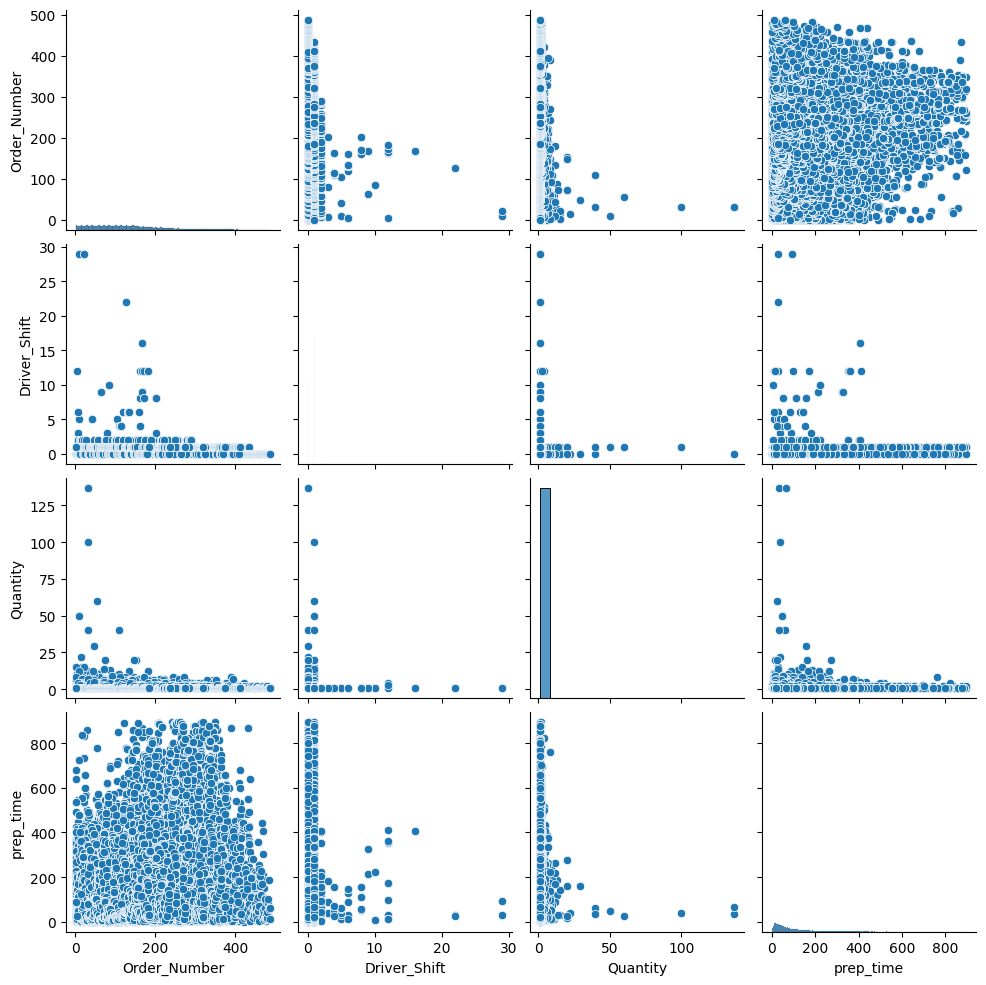

In [8]:
sns.pairplot(data=df)

<Axes: >

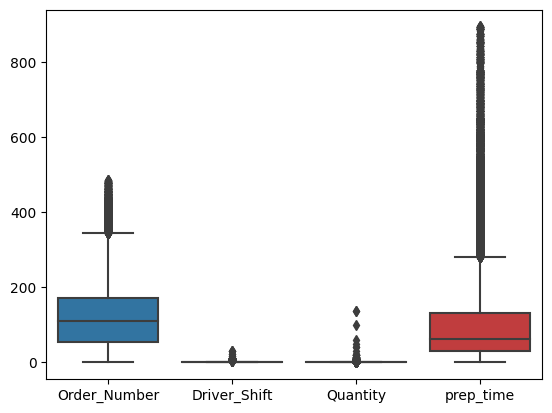

In [9]:
sns.boxplot(df)

In [10]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = sorted(Counter(df['Location_Code'].values.tolist()), reverse=True)
# allMenuCodes,
# allStoreIds
print(len(allMenuCodes))
print(len(allStoreIds))

146
12


In [11]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = df.loc[df['Location_Code'] == storeId]

In [12]:
def get_preparation_time(item):
    return item['prep_time']

In [13]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [14]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if stores[i] == storeId:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        for i in range(0, len(allStoreIds)):
            if item['Location_Code'] == allStoreIds[i]:
                return [i+1]
        return [-1]

In [15]:
# Feature 2 : Day of the week
def dayOfTheWeek(dt, isOneHotEncodingRequired=False):
    day = dt.weekday()
    if isOneHotEncodingRequired:
        days = [0, 0, 0, 0, 0, 0, 0]
        days[day] = 1
        return days
    else:
        return [day+1]

In [16]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

[3]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=False):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    if (isOneHotEncodingRequired):
        return getOneHotEncodingTimeSlot(timeslot)
    else:
        return [1+timeslot]

In [18]:
# Feature 4: Item Type
def getOneHotEncodedItemList(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodedItemList(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if items[i] == item:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, clubCategoryWise=False, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodedItemList(item['Menu_Code'], allMenuCodes, clubCategoryWise)
    else:
        for i in range(0, len(allMenuCodes)):
            if allMenuCodes[i] == item['Menu_Code']:
                return [i+1]
        print("DANGER DANGER DANGER \n\n\n")
        return [-1]

In [19]:
print(getItemType(sampleItem, False, True))
print(getItemType(sampleItem, True, False))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1]
[1]
[1]


In [20]:
# Feature 5 : Count of all baking items of all orders received by the store in the last 30 minutes.

def countPastOrders(item, slotTime=30):
    storeId = item['Location_Code']
    df = restWiseDFs[storeId]
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=slotTime)
    return len(df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
          (df['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [21]:
# Feature 6: ratio of items in last 30 minutes with items in the window of last 60 to 30 minutes (increment in orders)
def getLiftInOrders(item, slotTime = 30):
    a = countPastOrders(item, slotTime)
    item2 = item
    item2['Kitchen_Display_Time'] = item2['Kitchen_Display_Time'] - timedelta(minutes=slotTime)
    b = countPastOrders(item2, slotTime)
    if b != 0:
        return a/b
    else:
        return 1


In [22]:
# TIME CONSUMING (4 m 14 seconds for Bhopal)
# Feature 7 : Avg prep time of the same item in the same store in last 60 minutes.
# Feature 8 : Avg prep time of the same item in the same store in last 7 days.
for storeId in restWiseDFs:
    avgPrepTime = restWiseDFs[storeId]['prep_time'].mean()    
    restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
    restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
    restWiseDFs[storeId]['hourswise_avg_kpt'] = 0
    for index, item in restWiseDFs[storeId].iterrows():
        itemCode = item['Menu_Code']
        dtKitchenDisplay = item['Kitchen_Display_Time']
        lastTimeMinutes = dtKitchenDisplay - timedelta(minutes=60)
        lastTime = dtKitchenDisplay - timedelta(days=7)
        df3 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= lastTime) & \
                     (restWiseDFs[storeId]['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (restWiseDFs[storeId]['Menu_Code'] == itemCode)]
        df2 = df3.loc[df3['Kitchen_Display_Time'] >= lastTimeMinutes]
        if len(df2.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] = df2['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] =  avgPrepTime
        if len(df3.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] = df3['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] =  avgPrepTime


/tmp/ipykernel_224586/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_224586/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_224586/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_224586/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_224586/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_224586/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [23]:
def getPreviousPrepTime(item, timeslot = 60):
    if timeslot == 60:
        return item['avg_kpt_in_last_one_hour']
    elif timeslot == 7*24*60:
        return item['avg_kpt_in_last_7_days']
    else:
        itemCode = item['Menu_Code']
        df = restWiseDFs[item['Location_Code']]

        dtKitchenDisplay = item['Kitchen_Display_Time']

        lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)

        df2 = df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
                     (df['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (df['Menu_Code'] == itemCode)]
        if len(df2.index) != 0:
            return df2['prep_time'].mean()
        else:
            return restWiseDFs[storeId]['prep_time'].mean()

In [24]:
# Hourwise avg
# Feature 9 : Avg prep time of the same item in same store : hour wise + according to the day of the week
hourWiseAvg = {}
for store in allStoreIds:
    hourWiseAvg[store] = {}
    for i in range(1, 8):
        hourWiseAvg[store][i] = {}

for storeId in allStoreIds:
    hwa = []
    for index, item in restWiseDFs[storeId].iterrows():
        ts = getTimeslot(item['Kitchen_Display_Time'])
        d = dayOfTheWeek(item['Kitchen_Display_Time'])[0]
        if ts not in hourWiseAvg[storeId][d]:
            hourWiseAvg[storeId][d][ts] = {'val': 0, 'cnt': 0}
        if hourWiseAvg[storeId][d][ts]['cnt'] == 0:
            hwa.append(item['avg_kpt_in_last_one_hour'])
        else:
            hwa.append(hourWiseAvg[storeId][d][ts]['val']/hourWiseAvg[storeId][d][ts]['cnt'])
        hourWiseAvg[storeId][d][ts]['val'] += item['prep_time']
        hourWiseAvg[storeId][d][ts]['cnt'] += 1

    restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa

/tmp/ipykernel_224586/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_224586/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_224586/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [25]:
def getHourWiseAverage(item):
    return item["hour_wise_avg_kpt_of_the_day"]

In [26]:
# Feature 10 : Item quantity
def getQuantity(item):
    return item['Quantity']

In [27]:
# Feature 11 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = restWiseDFs[item['Location_Code']]
    return len(d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [28]:
sampleItem=None
for index, item in restWiseDFs[storeId].iterrows():
    sampleItem = item
    break

In [29]:
lengthQueue(sampleItem)

2

In [30]:
# global variables

clubItemsCategoryWise = False

splitMethod = 'initial 21 days'
slotTimeForPastOrders = 30 # minutes

model = 'xgboost'
isOneHotEncodingRequired = False
isNormalizationRequired = False

isCentralModel = True

In [31]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [32]:
save_object(restWiseDFs, f'restWiseDFsBeforeFeatureCreation{city}.pkl')

In [33]:
totalFeatures = (0 + # store ID (categorical)
                1 + # day of the week (categorical)
                1 +  #timeslot of the day (categorical)
                0 +  # Item type (categorical)
                1 +  #count past orders in last 30 minutes
                1 +  #ratio lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1 + # average kpt time, hour wise according to the day of the week
                0 + # Item quantity
                1) # length of the current queue

if isCentralModel:
    totalFeatures += 1
if isOneHotEncodingRequired:
    ##### DEPRECATED
    totalFeatures = (7 + # one hot encoded day of the week
                 len(allMenuCodes) +  # Item type
                24 +  #timeslot of the day
                1 +  #count past orders
                1 +  #lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1) # length of the current queue
    if isCentralModel:
        totalFeatures += len(allStoreIds)

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_'+str(i+1))

In [34]:
def updateFeatures(storeId, Xnp, fc=feature_cols):
    restWiseDFs[storeId][fc] = Xnp

In [35]:
# TIME CONSUMING (3m 21s for Bhopal)
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
#         features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot = 60)]
        features += [getPreviousPrepTime(item, timeslot = 7*24*60)]
        features += [getHourWiseAverage(item)]
#         features += [getQuantity(item)]
        features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)

/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10509, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12344, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16460, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(18798, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12105, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14284, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(17184, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10763, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12230, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9330, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10736, 9)
(11443, 9)


/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_224586/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [40]:
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 3):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")

/tmp/ipykernel_224586/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")


In [37]:
save_object(restWiseDFs, 'WithoutNormalization.pkl')

In [38]:
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 21)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
              (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:, feature_cols[4:]]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols[3:]]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            restWiseDFs[storeId][feature_cols[3:]] = X_scalednp
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')

In [39]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [41]:
if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
        
    firstTimeTrain = datetime(2022, 7, 1)
    lastTimeTrain = datetime(2022, 7, 21) + timedelta(days=1)
    
    firstTimeVal = datetime(2022, 7, 22)
    lastTimeVal = datetime(2022, 7, 31) + timedelta(days=1)
    
    firstTimeTest = datetime(2022, 7, 22)
    lastTimeTest = datetime(2022, 7, 31) + timedelta(days=1)

    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTrain) & \
          (overallDF['Kitchen_Display_Time'] < lastTimeTrain)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeVal) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeVal)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTest) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeTest)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()
    print("TRAIN TEST SPLITED")


    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['hist'],
        'n_estimators': [100, 150],
        'learning_rate': [0.08],
        'subsample': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'max_depth': [5, 6, 7],
    }
    
    {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9, 'tree_method': 'hist'}

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)
    
    print("FITTING TO GRID SEARCH START")
    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)
    

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train, y_train)
    
    print("MODEL PREPARED")
    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_train_val, y_train_val)
    print("Test score:", test_score)

    overallPredictions = best_regressor.predict(overallDF.loc[:, feature_cols])
    overallDF['predicted_prep_time_central'] = overallPredictions
    
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTrain) & \
          (overallDF['Kitchen_Display_Time'] < lastTimeTrain)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeVal) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeVal)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTest) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeTest)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    print("ACCURACY ON Train DATA : ")
    print("RMSE score: ", getRMSE(trainingData.prep_time.values.tolist(), best_regressor.predict(trainingData.loc[:, feature_cols])))
        
#     print("ACCURACY ON Validation DATA : ")
#     print("RMSE score: ", getRMSE(validationData.prep_time.values.tolist(), best_regressor.predict(validationData.loc[:, feature_cols])))

    print("ACCURACY ON Test DATA : ")
    print("RMSE score: ", getRMSE(testData.prep_time.values.tolist(), best_regressor.predict(testData.loc[:, feature_cols])))
    

    

TRAIN TEST SPLITED
FITTING TO GRID SEARCH START
Best hyperparameters: {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7, 'tree_method': 'hist'}
Best mean cross-validated score: 0.22569132724558152
MODEL PREPARED
Test score: 0.3110359403568477
ACCURACY ON Train DATA : 
RMSE score:  75.56758062004386
ACCURACY ON Test DATA : 
RMSE score:  94.67948255564373


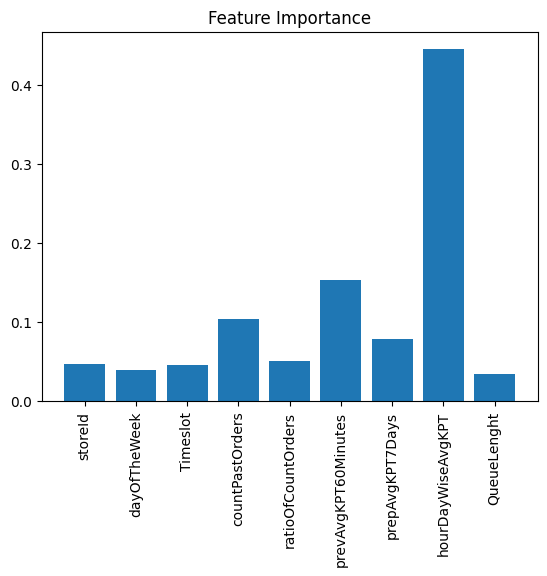

0.9999999143183231


In [45]:
f = ['storeId', 'dayOfTheWeek', 'Timeslot', 'countPastOrders', 'ratioOfCountOrders', 'prevAvgKPT60Minutes', 'prepAvgKPT7Days', 'hourDayWiseAvgKPT', 'QueueLenght']
pyplot.bar(f, best_regressor.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.title("Feature Importance")
pyplot.show()
print(sum(best_regressor.feature_importances_))

In [44]:
allDays = overallDF.Order_Date.unique()
for storeId in allStoreIds:
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
    for day in allDays:
        df2 = df.loc[df['Order_Date'] == day]
        timeslots = df2.feature_3.unique()
        for ts in sorted(timeslots):
            df3 = df2.loc[df2['feature_3'] == ts]
            l1 = df3.prep_time.values.tolist()
            l2 = df3.predicted_prep_time_central.values.tolist()
            l3 = df3.hour_wise_avg_kpt_of_the_day.values.tolist()
            rmseModel = getRMSE(l1, l2)
            rmseBaseline = getRMSE(l1, l3)
#             print(f"{day} \t {ts} \t {rmseModel} \t {rmseBaseline}")
            diffs.append(rmseModel-rmseBaseline)
# print(sorted(diffs))
diffs = sorted(diffs)
print(f"lowest: {diffs[0]}, highest: {diffs[len(diffs)-1]}, median: {diffs[len(diffs)//2]}")


lowest: -98.97661119395855, highest: 30.77781390427164, median: -1.4064971270967206


In [48]:
def getMAE(actual, predictions):
    mse = sklearn.metrics.mean_absolute_error(actual, predictions)
    return mse

def getDayOfTheWeek(a):
    if a==1:
        return "Monday"
    if a==2:
        return "Tuesday"
    if a==3:
        return "Wednesday"
    if a==4:
        return "Thursday"
    if a==5:
        return "Friday"
    if a==6:
        return "Saturday"
    if a==7:
        return "Sunday"

In [74]:
dfError = pd.DataFrame()
allDays = overallDF.Order_Date.unique()
for storeId in allStoreIds:
# for i in range(0, 1):
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
    for day in allDays:
        df2 = df.loc[df['Order_Date'] == day]
        for ts in sorted(timeslots):
            df3 = df2.loc[df['feature_3'] == ts]
            if(df3.size == 0):
                continue
            rmseModel = getRMSE(df3.prep_time.values.tolist(), df3.predicted_prep_time_central.values.tolist())
            rmseBaseline = getRMSE(df3.prep_time.values.tolist(), df3.hour_wise_avg_kpt_of_the_day.values.tolist())

            maeModel = getMAE(df3.prep_time.values.tolist(), df3.predicted_prep_time_central.values.tolist())
            maeBaseline = getMAE(df3.prep_time.values.tolist(), df3.hour_wise_avg_kpt_of_the_day.values.tolist())

            weekday = datetime.strptime(day, "%Y-%m-%d %H:%M:%S").weekday()
            print(f"Day : {day}, Week: {weekday}, ts: {ts}, Model RMSE: {rmseModel}, Baseline RMSE : {rmseBaseline}")
            a = {"storeId":[storeId], "date":[day], "timeslot":ts, "weekday": [getDayOfTheWeek(weekday)], "model rmse": [rmseModel], "baseline rmse": [rmseBaseline], "model mae": [maeModel], "baseline mae": [maeBaseline]}
            b = pd.DataFrame(a)
            dfError = pd.concat([dfError, b], ignore_index= True)
        
        

Day : 2022-07-01 00:00:00, Week: 4, ts: 12.0, Model RMSE: 5.164115297715929, Baseline RMSE : 17.31493384320469
Day : 2022-07-01 00:00:00, Week: 4, ts: 13.0, Model RMSE: 121.11340933289813, Baseline RMSE : 118.15991543621394
Day : 2022-07-01 00:00:00, Week: 4, ts: 14.0, Model RMSE: 74.46644905557194, Baseline RMSE : 85.33367153303617
Day : 2022-07-01 00:00:00, Week: 4, ts: 15.0, Model RMSE: 18.957384244462094, Baseline RMSE : 22.592124266331492
Day : 2022-07-01 00:00:00, Week: 4, ts: 16.0, Model RMSE: 52.13135015965573, Baseline RMSE : 43.986932304657614
Day : 2022-07-01 00:00:00, Week: 4, ts: 17.0, Model RMSE: 126.16692256255651, Baseline RMSE : 152.86394720752983
Day : 2022-07-01 00:00:00, Week: 4, ts: 18.0, Model RMSE: 41.144852339965745, Baseline RMSE : 46.78311269307169
Day : 2022-07-01 00:00:00, Week: 4, ts: 19.0, Model RMSE: 41.17883875791036, Baseline RMSE : 42.633290627238296
Day : 2022-07-01 00:00:00, Week: 4, ts: 20.0, Model RMSE: 50.13940192003593, Baseline RMSE : 50.0486184

Day : 2022-07-07 00:00:00, Week: 3, ts: 21.0, Model RMSE: 37.69732672636053, Baseline RMSE : 37.96607057848017
Day : 2022-07-07 00:00:00, Week: 3, ts: 22.0, Model RMSE: 27.940251269609533, Baseline RMSE : 30.549182997608423
Day : 2022-07-07 00:00:00, Week: 3, ts: 23.0, Model RMSE: 31.733527330507844, Baseline RMSE : 35.74133392555075
Day : 2022-07-07 00:00:00, Week: 3, ts: 24.0, Model RMSE: 36.31032119173155, Baseline RMSE : 40.03493574975679
Day : 2022-07-08 00:00:00, Week: 4, ts: 12.0, Model RMSE: 57.60187245907823, Baseline RMSE : 55.370509924273286
Day : 2022-07-08 00:00:00, Week: 4, ts: 13.0, Model RMSE: 49.659849159393524, Baseline RMSE : 50.910148305045944
Day : 2022-07-08 00:00:00, Week: 4, ts: 14.0, Model RMSE: 43.10740518500142, Baseline RMSE : 48.994482815731345
Day : 2022-07-08 00:00:00, Week: 4, ts: 15.0, Model RMSE: 48.060658921397625, Baseline RMSE : 49.395472618378705
Day : 2022-07-08 00:00:00, Week: 4, ts: 16.0, Model RMSE: 48.79202471865692, Baseline RMSE : 48.6296216

Day : 2022-07-19 00:00:00, Week: 1, ts: 18.0, Model RMSE: 26.751192428405428, Baseline RMSE : 24.974871397936408
Day : 2022-07-19 00:00:00, Week: 1, ts: 19.0, Model RMSE: 39.29658279825407, Baseline RMSE : 39.72981727352369
Day : 2022-07-19 00:00:00, Week: 1, ts: 20.0, Model RMSE: 54.222651223123655, Baseline RMSE : 53.77179245541149
Day : 2022-07-19 00:00:00, Week: 1, ts: 21.0, Model RMSE: 58.67334557186325, Baseline RMSE : 56.192823346392956
Day : 2022-07-19 00:00:00, Week: 1, ts: 22.0, Model RMSE: 30.682200982112754, Baseline RMSE : 32.60080672588167
Day : 2022-07-19 00:00:00, Week: 1, ts: 23.0, Model RMSE: 33.9955728716533, Baseline RMSE : 33.433718508062704
Day : 2022-07-19 00:00:00, Week: 1, ts: 24.0, Model RMSE: 91.26033999466726, Baseline RMSE : 86.73611751856087
Day : 2022-07-20 00:00:00, Week: 2, ts: 12.0, Model RMSE: 53.049894109768154, Baseline RMSE : 51.438488657106
Day : 2022-07-20 00:00:00, Week: 2, ts: 13.0, Model RMSE: 34.36345808284653, Baseline RMSE : 39.159129343692

Day : 2022-07-30 00:00:00, Week: 5, ts: 15.0, Model RMSE: 145.90061698276895, Baseline RMSE : 145.89038171151984
Day : 2022-07-30 00:00:00, Week: 5, ts: 16.0, Model RMSE: 88.67483263407368, Baseline RMSE : 95.27476970239623
Day : 2022-07-30 00:00:00, Week: 5, ts: 17.0, Model RMSE: 186.95004252132796, Baseline RMSE : 185.81253449447823
Day : 2022-07-30 00:00:00, Week: 5, ts: 18.0, Model RMSE: 76.73614605830191, Baseline RMSE : 78.26752111513136
Day : 2022-07-30 00:00:00, Week: 5, ts: 19.0, Model RMSE: 82.98215300471561, Baseline RMSE : 86.63787910445213
Day : 2022-07-30 00:00:00, Week: 5, ts: 20.0, Model RMSE: 175.74055231519083, Baseline RMSE : 182.4951380628749
Day : 2022-07-30 00:00:00, Week: 5, ts: 21.0, Model RMSE: 58.57924251102399, Baseline RMSE : 43.37751109158567
Day : 2022-07-30 00:00:00, Week: 5, ts: 22.0, Model RMSE: 67.07399041278008, Baseline RMSE : 90.33996998778845
Day : 2022-07-30 00:00:00, Week: 5, ts: 23.0, Model RMSE: 81.4083126144493, Baseline RMSE : 93.904337231132

Day : 2022-07-05 00:00:00, Week: 1, ts: 17.0, Model RMSE: 35.313911402358535, Baseline RMSE : 37.39278279611387
Day : 2022-07-05 00:00:00, Week: 1, ts: 18.0, Model RMSE: 101.89307793518184, Baseline RMSE : 107.31248220710965
Day : 2022-07-05 00:00:00, Week: 1, ts: 19.0, Model RMSE: 45.18365911278294, Baseline RMSE : 48.91497328228313
Day : 2022-07-05 00:00:00, Week: 1, ts: 20.0, Model RMSE: 54.563055181277186, Baseline RMSE : 57.37068583907473
Day : 2022-07-05 00:00:00, Week: 1, ts: 21.0, Model RMSE: 97.38307726212338, Baseline RMSE : 102.17594493816095
Day : 2022-07-05 00:00:00, Week: 1, ts: 22.0, Model RMSE: 108.58817906397705, Baseline RMSE : 109.39874103866853
Day : 2022-07-05 00:00:00, Week: 1, ts: 23.0, Model RMSE: 50.54379621614788, Baseline RMSE : 50.01068555059848
Day : 2022-07-06 00:00:00, Week: 2, ts: 12.0, Model RMSE: 48.229432080081736, Baseline RMSE : 53.508229164001364
Day : 2022-07-06 00:00:00, Week: 2, ts: 13.0, Model RMSE: 52.35361733130707, Baseline RMSE : 54.7639937

Day : 2022-07-17 00:00:00, Week: 6, ts: 12.0, Model RMSE: 21.366135152207722, Baseline RMSE : 21.70115392552777
Day : 2022-07-17 00:00:00, Week: 6, ts: 13.0, Model RMSE: 25.979327467972738, Baseline RMSE : 22.56721013053695
Day : 2022-07-17 00:00:00, Week: 6, ts: 14.0, Model RMSE: 90.2839132780333, Baseline RMSE : 103.48713859060967
Day : 2022-07-17 00:00:00, Week: 6, ts: 15.0, Model RMSE: 27.157513462944014, Baseline RMSE : 31.76279736766698
Day : 2022-07-17 00:00:00, Week: 6, ts: 16.0, Model RMSE: 52.50863339106412, Baseline RMSE : 52.358924528566
Day : 2022-07-17 00:00:00, Week: 6, ts: 17.0, Model RMSE: 33.1398790645305, Baseline RMSE : 31.93530654344202
Day : 2022-07-17 00:00:00, Week: 6, ts: 18.0, Model RMSE: 65.13504024513787, Baseline RMSE : 64.72515271672208
Day : 2022-07-17 00:00:00, Week: 6, ts: 19.0, Model RMSE: 53.78796128034786, Baseline RMSE : 50.03237792847916
Day : 2022-07-17 00:00:00, Week: 6, ts: 20.0, Model RMSE: 149.79888285562527, Baseline RMSE : 163.07665610101503

Day : 2022-07-23 00:00:00, Week: 5, ts: 13.0, Model RMSE: 41.752299576275135, Baseline RMSE : 43.77011483535941
Day : 2022-07-23 00:00:00, Week: 5, ts: 14.0, Model RMSE: 68.86755208210478, Baseline RMSE : 69.32305695046145
Day : 2022-07-23 00:00:00, Week: 5, ts: 15.0, Model RMSE: 37.541428043103586, Baseline RMSE : 32.31786625008009
Day : 2022-07-23 00:00:00, Week: 5, ts: 16.0, Model RMSE: 32.011505369894216, Baseline RMSE : 33.89532813627301
Day : 2022-07-23 00:00:00, Week: 5, ts: 17.0, Model RMSE: 23.67899752784035, Baseline RMSE : 25.12865207022537
Day : 2022-07-23 00:00:00, Week: 5, ts: 18.0, Model RMSE: 52.60010094650208, Baseline RMSE : 55.735015074417745
Day : 2022-07-23 00:00:00, Week: 5, ts: 19.0, Model RMSE: 68.84330787554448, Baseline RMSE : 69.41714318540895
Day : 2022-07-23 00:00:00, Week: 5, ts: 20.0, Model RMSE: 102.57055762516494, Baseline RMSE : 109.88116545586573
Day : 2022-07-23 00:00:00, Week: 5, ts: 21.0, Model RMSE: 102.15042995358029, Baseline RMSE : 114.76289983

Day : 2022-07-29 00:00:00, Week: 4, ts: 15.0, Model RMSE: 31.032137172435394, Baseline RMSE : 29.700701350674972
Day : 2022-07-29 00:00:00, Week: 4, ts: 16.0, Model RMSE: 28.054114468514566, Baseline RMSE : 23.807283729237113
Day : 2022-07-29 00:00:00, Week: 4, ts: 17.0, Model RMSE: 32.57995715160803, Baseline RMSE : 44.27141988133027
Day : 2022-07-29 00:00:00, Week: 4, ts: 18.0, Model RMSE: 115.21879163304047, Baseline RMSE : 116.93929378924774
Day : 2022-07-29 00:00:00, Week: 4, ts: 19.0, Model RMSE: 51.44003382768261, Baseline RMSE : 53.72353993754383
Day : 2022-07-29 00:00:00, Week: 4, ts: 20.0, Model RMSE: 38.39191268794275, Baseline RMSE : 39.23745917286281
Day : 2022-07-29 00:00:00, Week: 4, ts: 21.0, Model RMSE: 110.54802818041308, Baseline RMSE : 106.06776583037258
Day : 2022-07-29 00:00:00, Week: 4, ts: 22.0, Model RMSE: 71.90891831467395, Baseline RMSE : 78.90946745742245
Day : 2022-07-29 00:00:00, Week: 4, ts: 23.0, Model RMSE: 42.83786583843175, Baseline RMSE : 43.67159128

Day : 2022-07-04 00:00:00, Week: 0, ts: 19.0, Model RMSE: 72.07606876708356, Baseline RMSE : 70.77333523863274
Day : 2022-07-04 00:00:00, Week: 0, ts: 20.0, Model RMSE: 63.451226803218276, Baseline RMSE : 70.15268337190007
Day : 2022-07-04 00:00:00, Week: 0, ts: 21.0, Model RMSE: 71.9116481538169, Baseline RMSE : 79.42096163198804
Day : 2022-07-04 00:00:00, Week: 0, ts: 22.0, Model RMSE: 44.95475591085578, Baseline RMSE : 42.96535347472445
Day : 2022-07-04 00:00:00, Week: 0, ts: 23.0, Model RMSE: 62.0997514249922, Baseline RMSE : 62.20869718462769
Day : 2022-07-04 00:00:00, Week: 0, ts: 24.0, Model RMSE: 54.668809113621094, Baseline RMSE : 65.25303894238725
Day : 2022-07-05 00:00:00, Week: 1, ts: 12.0, Model RMSE: 72.46083541168099, Baseline RMSE : 77.11495020522126
Day : 2022-07-05 00:00:00, Week: 1, ts: 13.0, Model RMSE: 106.26166514160315, Baseline RMSE : 108.60487570012621
Day : 2022-07-05 00:00:00, Week: 1, ts: 14.0, Model RMSE: 51.3496903683572, Baseline RMSE : 55.960027212967105

Day : 2022-07-10 00:00:00, Week: 6, ts: 21.0, Model RMSE: 89.94818281923892, Baseline RMSE : 263.87796430215434
Day : 2022-07-10 00:00:00, Week: 6, ts: 22.0, Model RMSE: 116.99953809119022, Baseline RMSE : 130.0111256001229
Day : 2022-07-10 00:00:00, Week: 6, ts: 23.0, Model RMSE: 98.9242213461531, Baseline RMSE : 100.67259395277061
Day : 2022-07-10 00:00:00, Week: 6, ts: 24.0, Model RMSE: 70.46743282780565, Baseline RMSE : 92.74943162214853
Day : 2022-07-11 00:00:00, Week: 0, ts: 12.0, Model RMSE: 86.84020763584698, Baseline RMSE : 76.2280689804999
Day : 2022-07-11 00:00:00, Week: 0, ts: 13.0, Model RMSE: 63.66216551230974, Baseline RMSE : 85.92559004423623
Day : 2022-07-11 00:00:00, Week: 0, ts: 14.0, Model RMSE: 27.718481901868635, Baseline RMSE : 35.60622759372672
Day : 2022-07-11 00:00:00, Week: 0, ts: 15.0, Model RMSE: 71.22032445374882, Baseline RMSE : 80.77513666540922
Day : 2022-07-11 00:00:00, Week: 0, ts: 16.0, Model RMSE: 53.07765118479682, Baseline RMSE : 46.42018291153042

Day : 2022-07-16 00:00:00, Week: 5, ts: 23.0, Model RMSE: 108.48510444732477, Baseline RMSE : 125.72127485951172
Day : 2022-07-16 00:00:00, Week: 5, ts: 24.0, Model RMSE: 48.271235245495795, Baseline RMSE : 52.93012498186712
Day : 2022-07-17 00:00:00, Week: 6, ts: 12.0, Model RMSE: 60.89393805503684, Baseline RMSE : 105.15126764118311
Day : 2022-07-17 00:00:00, Week: 6, ts: 13.0, Model RMSE: 35.90929655406862, Baseline RMSE : 28.768828605693354
Day : 2022-07-17 00:00:00, Week: 6, ts: 14.0, Model RMSE: 55.4445717421955, Baseline RMSE : 75.58540362825794
Day : 2022-07-17 00:00:00, Week: 6, ts: 15.0, Model RMSE: 89.50658508345305, Baseline RMSE : 89.41742407890892
Day : 2022-07-17 00:00:00, Week: 6, ts: 16.0, Model RMSE: 53.18542536809797, Baseline RMSE : 59.55652732048822
Day : 2022-07-17 00:00:00, Week: 6, ts: 17.0, Model RMSE: 63.42702393984204, Baseline RMSE : 61.38863012045932
Day : 2022-07-17 00:00:00, Week: 6, ts: 18.0, Model RMSE: 63.16229248119127, Baseline RMSE : 85.891034994367

Day : 2022-07-23 00:00:00, Week: 5, ts: 12.0, Model RMSE: 38.915393568463905, Baseline RMSE : 36.91916545799077
Day : 2022-07-23 00:00:00, Week: 5, ts: 13.0, Model RMSE: 62.14873087097365, Baseline RMSE : 68.82646043234523
Day : 2022-07-23 00:00:00, Week: 5, ts: 14.0, Model RMSE: 54.41965351896765, Baseline RMSE : 72.77939525236206
Day : 2022-07-23 00:00:00, Week: 5, ts: 15.0, Model RMSE: 61.43033336802736, Baseline RMSE : 73.44652185078091
Day : 2022-07-23 00:00:00, Week: 5, ts: 16.0, Model RMSE: 100.47404221909433, Baseline RMSE : 100.36783624184979
Day : 2022-07-23 00:00:00, Week: 5, ts: 17.0, Model RMSE: 52.36242676326379, Baseline RMSE : 46.81361975869735
Day : 2022-07-23 00:00:00, Week: 5, ts: 18.0, Model RMSE: 58.00816504762966, Baseline RMSE : 60.372814291848826
Day : 2022-07-23 00:00:00, Week: 5, ts: 19.0, Model RMSE: 69.33315721531172, Baseline RMSE : 63.36071644288405
Day : 2022-07-23 00:00:00, Week: 5, ts: 20.0, Model RMSE: 65.12997958706723, Baseline RMSE : 59.421033043355

Day : 2022-07-29 00:00:00, Week: 4, ts: 21.0, Model RMSE: 113.44522213747376, Baseline RMSE : 93.67756574280129
Day : 2022-07-29 00:00:00, Week: 4, ts: 22.0, Model RMSE: 78.3962375509828, Baseline RMSE : 97.28069789404078
Day : 2022-07-29 00:00:00, Week: 4, ts: 23.0, Model RMSE: 69.12453564011977, Baseline RMSE : 66.38412741373435
Day : 2022-07-29 00:00:00, Week: 4, ts: 24.0, Model RMSE: 68.68514472932256, Baseline RMSE : 69.94457816512295
Day : 2022-07-30 00:00:00, Week: 5, ts: 12.0, Model RMSE: 35.4083634319977, Baseline RMSE : 40.89122359756787
Day : 2022-07-30 00:00:00, Week: 5, ts: 13.0, Model RMSE: 59.94811818221389, Baseline RMSE : 60.54987996840087
Day : 2022-07-30 00:00:00, Week: 5, ts: 14.0, Model RMSE: 60.13468151030756, Baseline RMSE : 78.59778677027802
Day : 2022-07-30 00:00:00, Week: 5, ts: 15.0, Model RMSE: 49.833722833718305, Baseline RMSE : 68.44247748351815
Day : 2022-07-30 00:00:00, Week: 5, ts: 16.0, Model RMSE: 88.98835988166819, Baseline RMSE : 89.57518629478074
D

Day : 2022-07-04 00:00:00, Week: 0, ts: 24.0, Model RMSE: 93.74028020005795, Baseline RMSE : 122.96523378659914
Day : 2022-07-05 00:00:00, Week: 1, ts: 12.0, Model RMSE: 78.420877048008, Baseline RMSE : 98.77900882619045
Day : 2022-07-05 00:00:00, Week: 1, ts: 13.0, Model RMSE: 40.78024728027402, Baseline RMSE : 50.775633675582
Day : 2022-07-05 00:00:00, Week: 1, ts: 14.0, Model RMSE: 148.59210666152924, Baseline RMSE : 183.81066547847783
Day : 2022-07-05 00:00:00, Week: 1, ts: 15.0, Model RMSE: 132.95124104937054, Baseline RMSE : 136.96927529920964
Day : 2022-07-05 00:00:00, Week: 1, ts: 16.0, Model RMSE: 134.97961925898852, Baseline RMSE : 157.35575584391975
Day : 2022-07-05 00:00:00, Week: 1, ts: 17.0, Model RMSE: 98.37088576306022, Baseline RMSE : 101.91295466033485
Day : 2022-07-05 00:00:00, Week: 1, ts: 18.0, Model RMSE: 119.71115971085895, Baseline RMSE : 127.53109476544954
Day : 2022-07-05 00:00:00, Week: 1, ts: 19.0, Model RMSE: 147.82227455172116, Baseline RMSE : 137.03064797

Day : 2022-07-11 00:00:00, Week: 0, ts: 12.0, Model RMSE: 42.78510623561721, Baseline RMSE : 69.28840039981887
Day : 2022-07-11 00:00:00, Week: 0, ts: 13.0, Model RMSE: 79.29057653901634, Baseline RMSE : 99.07049472473872
Day : 2022-07-11 00:00:00, Week: 0, ts: 14.0, Model RMSE: 91.8784234266653, Baseline RMSE : 125.19247557134766
Day : 2022-07-11 00:00:00, Week: 0, ts: 15.0, Model RMSE: 86.95344551585251, Baseline RMSE : 108.51860392304005
Day : 2022-07-11 00:00:00, Week: 0, ts: 16.0, Model RMSE: 84.55027165814849, Baseline RMSE : 96.2200013653983
Day : 2022-07-11 00:00:00, Week: 0, ts: 17.0, Model RMSE: 54.413704064178596, Baseline RMSE : 50.041024373368515
Day : 2022-07-11 00:00:00, Week: 0, ts: 18.0, Model RMSE: 73.45569610633038, Baseline RMSE : 118.52493140155089
Day : 2022-07-11 00:00:00, Week: 0, ts: 19.0, Model RMSE: 85.50644136390525, Baseline RMSE : 95.2079708434427
Day : 2022-07-11 00:00:00, Week: 0, ts: 20.0, Model RMSE: 111.76442789374838, Baseline RMSE : 115.780110462056

Day : 2022-07-17 00:00:00, Week: 6, ts: 21.0, Model RMSE: 162.59839405994876, Baseline RMSE : 228.644453428867
Day : 2022-07-17 00:00:00, Week: 6, ts: 22.0, Model RMSE: 195.69987061083975, Baseline RMSE : 311.2863379105647
Day : 2022-07-17 00:00:00, Week: 6, ts: 23.0, Model RMSE: 159.0655396477104, Baseline RMSE : 176.85925455596833
Day : 2022-07-17 00:00:00, Week: 6, ts: 24.0, Model RMSE: 129.09363218722788, Baseline RMSE : 124.67918779973762
Day : 2022-07-18 00:00:00, Week: 0, ts: 12.0, Model RMSE: 45.33017283556972, Baseline RMSE : 48.51995457214915
Day : 2022-07-18 00:00:00, Week: 0, ts: 13.0, Model RMSE: 81.34358056404953, Baseline RMSE : 84.73168433625393
Day : 2022-07-18 00:00:00, Week: 0, ts: 14.0, Model RMSE: 47.48638893474196, Baseline RMSE : 72.5888653280193
Day : 2022-07-18 00:00:00, Week: 0, ts: 15.0, Model RMSE: 70.96599686697051, Baseline RMSE : 90.28865499205605
Day : 2022-07-18 00:00:00, Week: 0, ts: 16.0, Model RMSE: 56.619798390963446, Baseline RMSE : 76.081759886599

Day : 2022-07-24 00:00:00, Week: 6, ts: 14.0, Model RMSE: 68.58618302692904, Baseline RMSE : 65.36735105254415
Day : 2022-07-24 00:00:00, Week: 6, ts: 15.0, Model RMSE: 116.39469896622053, Baseline RMSE : 134.2784676946767
Day : 2022-07-24 00:00:00, Week: 6, ts: 16.0, Model RMSE: 102.60038768901316, Baseline RMSE : 99.23968666487987
Day : 2022-07-24 00:00:00, Week: 6, ts: 17.0, Model RMSE: 124.64170501084482, Baseline RMSE : 138.13021123211038
Day : 2022-07-24 00:00:00, Week: 6, ts: 18.0, Model RMSE: 176.80440822032895, Baseline RMSE : 175.26822110576634
Day : 2022-07-24 00:00:00, Week: 6, ts: 19.0, Model RMSE: 75.13936441833593, Baseline RMSE : 90.83982895405956
Day : 2022-07-24 00:00:00, Week: 6, ts: 20.0, Model RMSE: 105.37854806092248, Baseline RMSE : 108.7599451110334
Day : 2022-07-24 00:00:00, Week: 6, ts: 21.0, Model RMSE: 193.52425748043018, Baseline RMSE : 214.28524787434193
Day : 2022-07-24 00:00:00, Week: 6, ts: 22.0, Model RMSE: 265.2408085346086, Baseline RMSE : 279.795318

Day : 2022-07-30 00:00:00, Week: 5, ts: 21.0, Model RMSE: 232.20281034418218, Baseline RMSE : 230.86282663809962
Day : 2022-07-30 00:00:00, Week: 5, ts: 22.0, Model RMSE: 181.65817075771906, Baseline RMSE : 183.07940810827944
Day : 2022-07-30 00:00:00, Week: 5, ts: 23.0, Model RMSE: 172.75146087252526, Baseline RMSE : 159.1734622132249
Day : 2022-07-30 00:00:00, Week: 5, ts: 24.0, Model RMSE: 167.05859108696697, Baseline RMSE : 140.60405025761474
Day : 2022-07-31 00:00:00, Week: 6, ts: 12.0, Model RMSE: 37.924818192944976, Baseline RMSE : 33.39091999032788
Day : 2022-07-31 00:00:00, Week: 6, ts: 13.0, Model RMSE: 45.911812580485766, Baseline RMSE : 44.17320757748251
Day : 2022-07-31 00:00:00, Week: 6, ts: 14.0, Model RMSE: 137.6029101092921, Baseline RMSE : 124.90231708644447
Day : 2022-07-31 00:00:00, Week: 6, ts: 15.0, Model RMSE: 90.60049227195752, Baseline RMSE : 77.54402374125381
Day : 2022-07-31 00:00:00, Week: 6, ts: 16.0, Model RMSE: 68.8124859164354, Baseline RMSE : 85.6520724

Day : 2022-07-06 00:00:00, Week: 2, ts: 20.0, Model RMSE: 88.51564786780652, Baseline RMSE : 103.334394726807
Day : 2022-07-06 00:00:00, Week: 2, ts: 21.0, Model RMSE: 19.74189058666476, Baseline RMSE : 6.563333141603696
Day : 2022-07-06 00:00:00, Week: 2, ts: 24.0, Model RMSE: 33.49404553283874, Baseline RMSE : 44.59710063366345
Day : 2022-07-07 00:00:00, Week: 3, ts: 12.0, Model RMSE: 27.068091649055713, Baseline RMSE : 33.610062937691985
Day : 2022-07-07 00:00:00, Week: 3, ts: 13.0, Model RMSE: 36.2801092262117, Baseline RMSE : 25.586743847911944
Day : 2022-07-07 00:00:00, Week: 3, ts: 14.0, Model RMSE: 14.310489874094575, Baseline RMSE : 23.959043883041026
Day : 2022-07-07 00:00:00, Week: 3, ts: 15.0, Model RMSE: 38.54908408999264, Baseline RMSE : 41.03165040804501
Day : 2022-07-07 00:00:00, Week: 3, ts: 16.0, Model RMSE: 35.09618008419458, Baseline RMSE : 40.43852796288708
Day : 2022-07-07 00:00:00, Week: 3, ts: 17.0, Model RMSE: 32.116734808140876, Baseline RMSE : 29.909179011491

Day : 2022-07-13 00:00:00, Week: 2, ts: 21.0, Model RMSE: 135.47898821773046, Baseline RMSE : 135.67746244102594
Day : 2022-07-13 00:00:00, Week: 2, ts: 22.0, Model RMSE: 63.48608679612925, Baseline RMSE : 63.137178456481564
Day : 2022-07-13 00:00:00, Week: 2, ts: 23.0, Model RMSE: 52.025942207695515, Baseline RMSE : 56.91079050967351
Day : 2022-07-13 00:00:00, Week: 2, ts: 24.0, Model RMSE: 180.91261389478552, Baseline RMSE : 201.2345598215117
Day : 2022-07-14 00:00:00, Week: 3, ts: 12.0, Model RMSE: 153.43776996992386, Baseline RMSE : 152.1776704739619
Day : 2022-07-14 00:00:00, Week: 3, ts: 13.0, Model RMSE: 98.09896733071565, Baseline RMSE : 109.62419574974948
Day : 2022-07-14 00:00:00, Week: 3, ts: 14.0, Model RMSE: 36.990575508256, Baseline RMSE : 38.973298667764354
Day : 2022-07-14 00:00:00, Week: 3, ts: 15.0, Model RMSE: 55.004256659107604, Baseline RMSE : 68.0959227454836
Day : 2022-07-14 00:00:00, Week: 3, ts: 16.0, Model RMSE: 34.71842901893722, Baseline RMSE : 31.4185858422

Day : 2022-07-20 00:00:00, Week: 2, ts: 15.0, Model RMSE: 34.55378357551341, Baseline RMSE : 35.80625473389418
Day : 2022-07-20 00:00:00, Week: 2, ts: 16.0, Model RMSE: 50.77436110746755, Baseline RMSE : 55.070966710415334
Day : 2022-07-20 00:00:00, Week: 2, ts: 17.0, Model RMSE: 29.92183385738505, Baseline RMSE : 33.714374071142544
Day : 2022-07-20 00:00:00, Week: 2, ts: 18.0, Model RMSE: 43.84044773377325, Baseline RMSE : 61.726623192898714
Day : 2022-07-20 00:00:00, Week: 2, ts: 19.0, Model RMSE: 57.080259614411304, Baseline RMSE : 67.1981529489427
Day : 2022-07-20 00:00:00, Week: 2, ts: 20.0, Model RMSE: 59.81896727264824, Baseline RMSE : 76.55032839848562
Day : 2022-07-20 00:00:00, Week: 2, ts: 21.0, Model RMSE: 74.82593112522144, Baseline RMSE : 84.23861325055313
Day : 2022-07-20 00:00:00, Week: 2, ts: 22.0, Model RMSE: 91.74056019425376, Baseline RMSE : 96.23076155341518
Day : 2022-07-20 00:00:00, Week: 2, ts: 23.0, Model RMSE: 125.6491219523101, Baseline RMSE : 137.645205626930

Day : 2022-07-26 00:00:00, Week: 1, ts: 16.0, Model RMSE: 39.13127262085639, Baseline RMSE : 57.40402558512892
Day : 2022-07-26 00:00:00, Week: 1, ts: 17.0, Model RMSE: 46.77054496338059, Baseline RMSE : 75.68314371113513
Day : 2022-07-26 00:00:00, Week: 1, ts: 18.0, Model RMSE: 45.20369496339987, Baseline RMSE : 50.563745996381094
Day : 2022-07-26 00:00:00, Week: 1, ts: 19.0, Model RMSE: 31.052968764882383, Baseline RMSE : 49.27252453204147
Day : 2022-07-26 00:00:00, Week: 1, ts: 20.0, Model RMSE: 33.40935579496756, Baseline RMSE : 49.14039512071291
Day : 2022-07-26 00:00:00, Week: 1, ts: 21.0, Model RMSE: 61.69752715886556, Baseline RMSE : 40.302029399814444
Day : 2022-07-26 00:00:00, Week: 1, ts: 22.0, Model RMSE: 104.22476126736623, Baseline RMSE : 99.50422519952187
Day : 2022-07-26 00:00:00, Week: 1, ts: 23.0, Model RMSE: 83.82862864286872, Baseline RMSE : 89.58973875502431
Day : 2022-07-26 00:00:00, Week: 1, ts: 24.0, Model RMSE: 37.042185379509526, Baseline RMSE : 30.55103216630

Day : 2022-07-01 00:00:00, Week: 4, ts: 24.0, Model RMSE: 19.83155329472687, Baseline RMSE : 7.444656803276562
Day : 2022-07-02 00:00:00, Week: 5, ts: 12.0, Model RMSE: 21.457952822664183, Baseline RMSE : 23.29647251359146
Day : 2022-07-02 00:00:00, Week: 5, ts: 13.0, Model RMSE: 138.7310018497687, Baseline RMSE : 137.93971176232586
Day : 2022-07-02 00:00:00, Week: 5, ts: 14.0, Model RMSE: 27.21380850305011, Baseline RMSE : 28.79274722112857
Day : 2022-07-02 00:00:00, Week: 5, ts: 15.0, Model RMSE: 21.766075821879074, Baseline RMSE : 22.12762612756317
Day : 2022-07-02 00:00:00, Week: 5, ts: 16.0, Model RMSE: 14.04419691669454, Baseline RMSE : 15.861843798891945
Day : 2022-07-02 00:00:00, Week: 5, ts: 17.0, Model RMSE: 73.69069678583813, Baseline RMSE : 73.31127524845257
Day : 2022-07-02 00:00:00, Week: 5, ts: 18.0, Model RMSE: 24.73570694586432, Baseline RMSE : 25.384399764397497
Day : 2022-07-02 00:00:00, Week: 5, ts: 19.0, Model RMSE: 23.1880442854936, Baseline RMSE : 23.672211259641

Day : 2022-07-08 00:00:00, Week: 4, ts: 22.0, Model RMSE: 23.068030664292127, Baseline RMSE : 23.299182342737907
Day : 2022-07-08 00:00:00, Week: 4, ts: 23.0, Model RMSE: 29.02882900524407, Baseline RMSE : 30.562386874899577
Day : 2022-07-08 00:00:00, Week: 4, ts: 24.0, Model RMSE: 13.066790281668776, Baseline RMSE : 21.728757873442184
Day : 2022-07-09 00:00:00, Week: 5, ts: 12.0, Model RMSE: 27.854293249055125, Baseline RMSE : 29.043162336839572
Day : 2022-07-09 00:00:00, Week: 5, ts: 13.0, Model RMSE: 42.54901678848803, Baseline RMSE : 68.42390081854694
Day : 2022-07-09 00:00:00, Week: 5, ts: 14.0, Model RMSE: 16.334112833374522, Baseline RMSE : 16.01561499222696
Day : 2022-07-09 00:00:00, Week: 5, ts: 15.0, Model RMSE: 19.1630658734522, Baseline RMSE : 17.560677485034535
Day : 2022-07-09 00:00:00, Week: 5, ts: 16.0, Model RMSE: 21.486192508382015, Baseline RMSE : 21.419172786178557
Day : 2022-07-09 00:00:00, Week: 5, ts: 17.0, Model RMSE: 35.44979507856756, Baseline RMSE : 35.886245

Day : 2022-07-15 00:00:00, Week: 4, ts: 12.0, Model RMSE: 63.65234468350444, Baseline RMSE : 65.38610593640642
Day : 2022-07-15 00:00:00, Week: 4, ts: 13.0, Model RMSE: 28.54812069689908, Baseline RMSE : 28.458631140226284
Day : 2022-07-15 00:00:00, Week: 4, ts: 14.0, Model RMSE: 15.677728535650575, Baseline RMSE : 14.684352385210797
Day : 2022-07-15 00:00:00, Week: 4, ts: 15.0, Model RMSE: 18.012690457180643, Baseline RMSE : 18.88108980731072
Day : 2022-07-15 00:00:00, Week: 4, ts: 16.0, Model RMSE: 19.91179653087937, Baseline RMSE : 20.580826909675856
Day : 2022-07-15 00:00:00, Week: 4, ts: 17.0, Model RMSE: 14.640120523789605, Baseline RMSE : 14.746304060497126
Day : 2022-07-15 00:00:00, Week: 4, ts: 18.0, Model RMSE: 14.282672430907844, Baseline RMSE : 14.121987355911227
Day : 2022-07-15 00:00:00, Week: 4, ts: 19.0, Model RMSE: 13.37991387452407, Baseline RMSE : 11.675552760305271
Day : 2022-07-15 00:00:00, Week: 4, ts: 20.0, Model RMSE: 14.713283932828237, Baseline RMSE : 14.75676

Day : 2022-07-21 00:00:00, Week: 3, ts: 22.0, Model RMSE: 18.977508539221322, Baseline RMSE : 18.656819380530866
Day : 2022-07-21 00:00:00, Week: 3, ts: 23.0, Model RMSE: 37.90576286546955, Baseline RMSE : 37.534567907512326
Day : 2022-07-21 00:00:00, Week: 3, ts: 24.0, Model RMSE: 31.970361051860028, Baseline RMSE : 32.46469198480006
Day : 2022-07-22 00:00:00, Week: 4, ts: 12.0, Model RMSE: 70.56968722192863, Baseline RMSE : 69.53603787964178
Day : 2022-07-22 00:00:00, Week: 4, ts: 13.0, Model RMSE: 25.653827551970647, Baseline RMSE : 26.08920231062177
Day : 2022-07-22 00:00:00, Week: 4, ts: 14.0, Model RMSE: 59.30847106590944, Baseline RMSE : 59.662045998088516
Day : 2022-07-22 00:00:00, Week: 4, ts: 15.0, Model RMSE: 19.227299942854817, Baseline RMSE : 16.402164235346415
Day : 2022-07-22 00:00:00, Week: 4, ts: 16.0, Model RMSE: 15.671308176839874, Baseline RMSE : 13.701172671441284
Day : 2022-07-22 00:00:00, Week: 4, ts: 17.0, Model RMSE: 18.59960118689651, Baseline RMSE : 18.306714

Day : 2022-07-28 00:00:00, Week: 3, ts: 18.0, Model RMSE: 20.04481604355649, Baseline RMSE : 19.430884690191622
Day : 2022-07-28 00:00:00, Week: 3, ts: 19.0, Model RMSE: 17.15246125539667, Baseline RMSE : 20.21861392710418
Day : 2022-07-28 00:00:00, Week: 3, ts: 20.0, Model RMSE: 20.718042118628787, Baseline RMSE : 21.864151070983205
Day : 2022-07-28 00:00:00, Week: 3, ts: 21.0, Model RMSE: 17.027528298491994, Baseline RMSE : 17.17627773660571
Day : 2022-07-28 00:00:00, Week: 3, ts: 22.0, Model RMSE: 19.37226703672686, Baseline RMSE : 17.95058067528707
Day : 2022-07-28 00:00:00, Week: 3, ts: 23.0, Model RMSE: 21.563165736040776, Baseline RMSE : 20.65518018439717
Day : 2022-07-28 00:00:00, Week: 3, ts: 24.0, Model RMSE: 33.07671822075849, Baseline RMSE : 33.0808537408396
Day : 2022-07-29 00:00:00, Week: 4, ts: 12.0, Model RMSE: 48.20412459214319, Baseline RMSE : 42.52091391023647
Day : 2022-07-29 00:00:00, Week: 4, ts: 13.0, Model RMSE: 16.968179748089288, Baseline RMSE : 15.27432469193

Day : 2022-07-04 00:00:00, Week: 0, ts: 12.0, Model RMSE: 28.7213404712629, Baseline RMSE : 44.14479426609546
Day : 2022-07-04 00:00:00, Week: 0, ts: 13.0, Model RMSE: 28.239682515594513, Baseline RMSE : 34.66125500527148
Day : 2022-07-04 00:00:00, Week: 0, ts: 14.0, Model RMSE: 36.774549896218815, Baseline RMSE : 37.44801442672846
Day : 2022-07-04 00:00:00, Week: 0, ts: 16.0, Model RMSE: 25.296613950397024, Baseline RMSE : 27.292177313824613
Day : 2022-07-04 00:00:00, Week: 0, ts: 17.0, Model RMSE: 55.31479645448335, Baseline RMSE : 58.088734550407665
Day : 2022-07-04 00:00:00, Week: 0, ts: 18.0, Model RMSE: 114.88829819699227, Baseline RMSE : 120.49586090468472
Day : 2022-07-04 00:00:00, Week: 0, ts: 19.0, Model RMSE: 59.46524884917854, Baseline RMSE : 65.03328253685702
Day : 2022-07-04 00:00:00, Week: 0, ts: 20.0, Model RMSE: 97.65793337573211, Baseline RMSE : 112.49802816597548
Day : 2022-07-04 00:00:00, Week: 0, ts: 21.0, Model RMSE: 140.0111272516927, Baseline RMSE : 156.16324653

Day : 2022-07-11 00:00:00, Week: 0, ts: 13.0, Model RMSE: 72.68152184773834, Baseline RMSE : 75.17847320750887
Day : 2022-07-11 00:00:00, Week: 0, ts: 14.0, Model RMSE: 45.8951869002227, Baseline RMSE : 46.558113821556596
Day : 2022-07-11 00:00:00, Week: 0, ts: 15.0, Model RMSE: 74.18532892888226, Baseline RMSE : 70.87163271615778
Day : 2022-07-11 00:00:00, Week: 0, ts: 16.0, Model RMSE: 68.51057528365428, Baseline RMSE : 72.59977692593841
Day : 2022-07-11 00:00:00, Week: 0, ts: 17.0, Model RMSE: 59.53547674171199, Baseline RMSE : 58.158720191019086
Day : 2022-07-11 00:00:00, Week: 0, ts: 18.0, Model RMSE: 57.39970561889948, Baseline RMSE : 60.03807962053227
Day : 2022-07-11 00:00:00, Week: 0, ts: 19.0, Model RMSE: 107.3558375846135, Baseline RMSE : 105.22575761369235
Day : 2022-07-11 00:00:00, Week: 0, ts: 20.0, Model RMSE: 58.624180944924035, Baseline RMSE : 74.23473836360726
Day : 2022-07-11 00:00:00, Week: 0, ts: 21.0, Model RMSE: 81.9309221309494, Baseline RMSE : 156.6838723426129

Day : 2022-07-17 00:00:00, Week: 6, ts: 23.0, Model RMSE: 82.13117541544358, Baseline RMSE : 90.2870697372616
Day : 2022-07-17 00:00:00, Week: 6, ts: 24.0, Model RMSE: 53.67119350884168, Baseline RMSE : 53.809821245916474
Day : 2022-07-18 00:00:00, Week: 0, ts: 12.0, Model RMSE: 46.415905642361224, Baseline RMSE : 45.7138862987926
Day : 2022-07-18 00:00:00, Week: 0, ts: 13.0, Model RMSE: 32.49195212416768, Baseline RMSE : 29.39011780207834
Day : 2022-07-18 00:00:00, Week: 0, ts: 14.0, Model RMSE: 86.67622661447372, Baseline RMSE : 93.88652699638025
Day : 2022-07-18 00:00:00, Week: 0, ts: 15.0, Model RMSE: 39.39252116264745, Baseline RMSE : 51.40552694007445
Day : 2022-07-18 00:00:00, Week: 0, ts: 16.0, Model RMSE: 49.954113630741105, Baseline RMSE : 55.5824552936915
Day : 2022-07-18 00:00:00, Week: 0, ts: 17.0, Model RMSE: 44.393390106702064, Baseline RMSE : 53.85946961391537
Day : 2022-07-18 00:00:00, Week: 0, ts: 18.0, Model RMSE: 39.9176435555485, Baseline RMSE : 59.13440619367547
D

Day : 2022-07-24 00:00:00, Week: 6, ts: 12.0, Model RMSE: 38.757398261985514, Baseline RMSE : 38.996365812664585
Day : 2022-07-24 00:00:00, Week: 6, ts: 13.0, Model RMSE: 49.83754893477341, Baseline RMSE : 53.4692792770524
Day : 2022-07-24 00:00:00, Week: 6, ts: 14.0, Model RMSE: 36.294276907797084, Baseline RMSE : 27.378228172555602
Day : 2022-07-24 00:00:00, Week: 6, ts: 15.0, Model RMSE: 167.54492895085494, Baseline RMSE : 177.30879675333793
Day : 2022-07-24 00:00:00, Week: 6, ts: 16.0, Model RMSE: 61.390041372744136, Baseline RMSE : 69.61395381828679
Day : 2022-07-24 00:00:00, Week: 6, ts: 17.0, Model RMSE: 121.34765507199957, Baseline RMSE : 124.10055061759545
Day : 2022-07-24 00:00:00, Week: 6, ts: 18.0, Model RMSE: 206.2844082445091, Baseline RMSE : 202.31969270619567
Day : 2022-07-24 00:00:00, Week: 6, ts: 19.0, Model RMSE: 73.96260720067785, Baseline RMSE : 76.92533975438548
Day : 2022-07-24 00:00:00, Week: 6, ts: 20.0, Model RMSE: 195.67645757157442, Baseline RMSE : 174.94940

Day : 2022-07-30 00:00:00, Week: 5, ts: 20.0, Model RMSE: 145.07229873096648, Baseline RMSE : 91.67974754209186
Day : 2022-07-30 00:00:00, Week: 5, ts: 21.0, Model RMSE: 71.70031091016189, Baseline RMSE : 77.84684034666934
Day : 2022-07-30 00:00:00, Week: 5, ts: 22.0, Model RMSE: 104.80435638278836, Baseline RMSE : 108.95413419172175
Day : 2022-07-30 00:00:00, Week: 5, ts: 23.0, Model RMSE: 63.920209132329425, Baseline RMSE : 60.743650342294885
Day : 2022-07-30 00:00:00, Week: 5, ts: 24.0, Model RMSE: 37.73154427228623, Baseline RMSE : 41.776075959333866
Day : 2022-07-31 00:00:00, Week: 6, ts: 12.0, Model RMSE: 56.794660269047526, Baseline RMSE : 55.88994218214309
Day : 2022-07-31 00:00:00, Week: 6, ts: 13.0, Model RMSE: 37.65932389432512, Baseline RMSE : 61.024316957289734
Day : 2022-07-31 00:00:00, Week: 6, ts: 14.0, Model RMSE: 67.13438370609255, Baseline RMSE : 65.69380132887225
Day : 2022-07-31 00:00:00, Week: 6, ts: 15.0, Model RMSE: 99.32161882680123, Baseline RMSE : 95.45387944

Day : 2022-07-05 00:00:00, Week: 1, ts: 21.0, Model RMSE: 68.33122904243679, Baseline RMSE : 69.70305901681945
Day : 2022-07-05 00:00:00, Week: 1, ts: 22.0, Model RMSE: 70.10305930317695, Baseline RMSE : 76.357487281298
Day : 2022-07-05 00:00:00, Week: 1, ts: 23.0, Model RMSE: 50.45848794762683, Baseline RMSE : 49.45293174819627
Day : 2022-07-05 00:00:00, Week: 1, ts: 24.0, Model RMSE: 42.635315451361926, Baseline RMSE : 51.88970921915254
Day : 2022-07-06 00:00:00, Week: 2, ts: 12.0, Model RMSE: 11.167270596684144, Baseline RMSE : 9.129498404767206
Day : 2022-07-06 00:00:00, Week: 2, ts: 13.0, Model RMSE: 29.397847002556272, Baseline RMSE : 32.18923443068688
Day : 2022-07-06 00:00:00, Week: 2, ts: 14.0, Model RMSE: 26.944700444306342, Baseline RMSE : 34.198362522933756
Day : 2022-07-06 00:00:00, Week: 2, ts: 15.0, Model RMSE: 22.20788683891814, Baseline RMSE : 24.609789082948076
Day : 2022-07-06 00:00:00, Week: 2, ts: 16.0, Model RMSE: 66.35733209497009, Baseline RMSE : 70.683244426018

Day : 2022-07-12 00:00:00, Week: 1, ts: 22.0, Model RMSE: 82.50121345498461, Baseline RMSE : 87.47196770698977
Day : 2022-07-12 00:00:00, Week: 1, ts: 23.0, Model RMSE: 134.63563686831904, Baseline RMSE : 133.88017811133776
Day : 2022-07-12 00:00:00, Week: 1, ts: 24.0, Model RMSE: 94.65547557326884, Baseline RMSE : 92.10714613041382
Day : 2022-07-13 00:00:00, Week: 2, ts: 12.0, Model RMSE: 37.7421484375, Baseline RMSE : 48.439
Day : 2022-07-13 00:00:00, Week: 2, ts: 13.0, Model RMSE: 12.494234152937251, Baseline RMSE : 12.539681981415374
Day : 2022-07-13 00:00:00, Week: 2, ts: 14.0, Model RMSE: 17.21509377010713, Baseline RMSE : 14.039663602040317
Day : 2022-07-13 00:00:00, Week: 2, ts: 15.0, Model RMSE: 27.999973772559898, Baseline RMSE : 33.13091414463118
Day : 2022-07-13 00:00:00, Week: 2, ts: 16.0, Model RMSE: 17.165429017237695, Baseline RMSE : 27.003402701511476
Day : 2022-07-13 00:00:00, Week: 2, ts: 17.0, Model RMSE: 16.704844891647213, Baseline RMSE : 27.329205835512308
Day : 

Day : 2022-07-19 00:00:00, Week: 1, ts: 15.0, Model RMSE: 111.4554391202416, Baseline RMSE : 108.83190181858699
Day : 2022-07-19 00:00:00, Week: 1, ts: 16.0, Model RMSE: 28.56328294923498, Baseline RMSE : 25.547862996010718
Day : 2022-07-19 00:00:00, Week: 1, ts: 17.0, Model RMSE: 24.4037322569362, Baseline RMSE : 20.574839261748767
Day : 2022-07-19 00:00:00, Week: 1, ts: 18.0, Model RMSE: 20.168439179950244, Baseline RMSE : 29.902420112079028
Day : 2022-07-19 00:00:00, Week: 1, ts: 19.0, Model RMSE: 58.12512459518298, Baseline RMSE : 81.17748676892906
Day : 2022-07-19 00:00:00, Week: 1, ts: 20.0, Model RMSE: 108.416164008238, Baseline RMSE : 103.60539029521169
Day : 2022-07-19 00:00:00, Week: 1, ts: 21.0, Model RMSE: 61.96998637569584, Baseline RMSE : 57.07247915632926
Day : 2022-07-19 00:00:00, Week: 1, ts: 22.0, Model RMSE: 149.98686563830657, Baseline RMSE : 152.01477021202015
Day : 2022-07-19 00:00:00, Week: 1, ts: 23.0, Model RMSE: 82.30118242070118, Baseline RMSE : 82.3694406843

Day : 2022-07-25 00:00:00, Week: 0, ts: 24.0, Model RMSE: 98.05484185604823, Baseline RMSE : 94.32192971213993
Day : 2022-07-26 00:00:00, Week: 1, ts: 12.0, Model RMSE: 29.047788300890872, Baseline RMSE : 31.00986029931634
Day : 2022-07-26 00:00:00, Week: 1, ts: 13.0, Model RMSE: 23.647114996753096, Baseline RMSE : 25.230119226397022
Day : 2022-07-26 00:00:00, Week: 1, ts: 14.0, Model RMSE: 24.89500292604693, Baseline RMSE : 21.937254330578174
Day : 2022-07-26 00:00:00, Week: 1, ts: 15.0, Model RMSE: 34.648558201990014, Baseline RMSE : 45.29387332111479
Day : 2022-07-26 00:00:00, Week: 1, ts: 16.0, Model RMSE: 16.82998203544509, Baseline RMSE : 18.376832535884827
Day : 2022-07-26 00:00:00, Week: 1, ts: 17.0, Model RMSE: 17.530574822826942, Baseline RMSE : 18.996220221700323
Day : 2022-07-26 00:00:00, Week: 1, ts: 18.0, Model RMSE: 30.01461911582863, Baseline RMSE : 27.15754205202372
Day : 2022-07-26 00:00:00, Week: 1, ts: 19.0, Model RMSE: 31.63535156866937, Baseline RMSE : 48.09529712

Day : 2022-07-31 00:00:00, Week: 6, ts: 24.0, Model RMSE: 60.827101644026165, Baseline RMSE : 69.51415094905056
Day : 2022-07-01 00:00:00, Week: 4, ts: 12.0, Model RMSE: 19.48562808750788, Baseline RMSE : 19.285548114733427
Day : 2022-07-01 00:00:00, Week: 4, ts: 13.0, Model RMSE: 36.565490928493496, Baseline RMSE : 39.176040816844676
Day : 2022-07-01 00:00:00, Week: 4, ts: 14.0, Model RMSE: 61.345219333514166, Baseline RMSE : 63.367136276792785
Day : 2022-07-01 00:00:00, Week: 4, ts: 15.0, Model RMSE: 26.539733164287313, Baseline RMSE : 29.247701496940227
Day : 2022-07-01 00:00:00, Week: 4, ts: 16.0, Model RMSE: 20.230726593296474, Baseline RMSE : 21.157000094979
Day : 2022-07-01 00:00:00, Week: 4, ts: 17.0, Model RMSE: 43.35685979104236, Baseline RMSE : 43.79414774434641
Day : 2022-07-01 00:00:00, Week: 4, ts: 18.0, Model RMSE: 28.467061065134217, Baseline RMSE : 29.77780020758514
Day : 2022-07-01 00:00:00, Week: 4, ts: 19.0, Model RMSE: 89.33366090949409, Baseline RMSE : 86.12743487

Day : 2022-07-07 00:00:00, Week: 3, ts: 23.0, Model RMSE: 51.58078761856752, Baseline RMSE : 56.763408100191555
Day : 2022-07-08 00:00:00, Week: 4, ts: 12.0, Model RMSE: 37.7420560604933, Baseline RMSE : 42.36598388687635
Day : 2022-07-08 00:00:00, Week: 4, ts: 13.0, Model RMSE: 26.589592568160455, Baseline RMSE : 27.31498119953482
Day : 2022-07-08 00:00:00, Week: 4, ts: 14.0, Model RMSE: 38.071466210524314, Baseline RMSE : 37.48879736935494
Day : 2022-07-08 00:00:00, Week: 4, ts: 15.0, Model RMSE: 59.35888705240649, Baseline RMSE : 59.658903710939036
Day : 2022-07-08 00:00:00, Week: 4, ts: 16.0, Model RMSE: 65.46507716692608, Baseline RMSE : 66.17976213646774
Day : 2022-07-08 00:00:00, Week: 4, ts: 17.0, Model RMSE: 23.44513289069187, Baseline RMSE : 24.339059068351233
Day : 2022-07-08 00:00:00, Week: 4, ts: 18.0, Model RMSE: 57.11075558561589, Baseline RMSE : 56.997545271357914
Day : 2022-07-08 00:00:00, Week: 4, ts: 19.0, Model RMSE: 28.869412979293426, Baseline RMSE : 32.8518899629

Day : 2022-07-14 00:00:00, Week: 3, ts: 20.0, Model RMSE: 31.192366671382665, Baseline RMSE : 48.40688822172438
Day : 2022-07-14 00:00:00, Week: 3, ts: 21.0, Model RMSE: 42.01057844374451, Baseline RMSE : 42.606934834310955
Day : 2022-07-14 00:00:00, Week: 3, ts: 22.0, Model RMSE: 66.31178042879698, Baseline RMSE : 73.95852487533737
Day : 2022-07-14 00:00:00, Week: 3, ts: 23.0, Model RMSE: 21.57603861869675, Baseline RMSE : 19.068346176484926
Day : 2022-07-15 00:00:00, Week: 4, ts: 12.0, Model RMSE: 41.85013542907532, Baseline RMSE : 41.32513568769908
Day : 2022-07-15 00:00:00, Week: 4, ts: 13.0, Model RMSE: 20.847740817418003, Baseline RMSE : 20.04537458389011
Day : 2022-07-15 00:00:00, Week: 4, ts: 14.0, Model RMSE: 22.385073621189626, Baseline RMSE : 23.99613180023093
Day : 2022-07-15 00:00:00, Week: 4, ts: 15.0, Model RMSE: 28.32741255742431, Baseline RMSE : 29.092722283257714
Day : 2022-07-15 00:00:00, Week: 4, ts: 16.0, Model RMSE: 28.42427448423587, Baseline RMSE : 29.4675444637

Day : 2022-07-22 00:00:00, Week: 4, ts: 14.0, Model RMSE: 31.31766247852204, Baseline RMSE : 32.18827732052763
Day : 2022-07-22 00:00:00, Week: 4, ts: 15.0, Model RMSE: 42.37946446728985, Baseline RMSE : 43.38682006543146
Day : 2022-07-22 00:00:00, Week: 4, ts: 16.0, Model RMSE: 26.477561955954922, Baseline RMSE : 26.56842255603855
Day : 2022-07-22 00:00:00, Week: 4, ts: 17.0, Model RMSE: 59.81611304261364, Baseline RMSE : 58.986385100441524
Day : 2022-07-22 00:00:00, Week: 4, ts: 18.0, Model RMSE: 40.66875855913716, Baseline RMSE : 41.22723968121814
Day : 2022-07-22 00:00:00, Week: 4, ts: 19.0, Model RMSE: 27.781636575654396, Baseline RMSE : 29.202794611700288
Day : 2022-07-22 00:00:00, Week: 4, ts: 20.0, Model RMSE: 39.14918350681754, Baseline RMSE : 38.234162969059156
Day : 2022-07-22 00:00:00, Week: 4, ts: 21.0, Model RMSE: 48.83311713879511, Baseline RMSE : 47.553082312310934
Day : 2022-07-22 00:00:00, Week: 4, ts: 22.0, Model RMSE: 29.17599062055325, Baseline RMSE : 30.7154018336

Day : 2022-07-28 00:00:00, Week: 3, ts: 23.0, Model RMSE: 40.985948971923804, Baseline RMSE : 40.73607224130434
Day : 2022-07-29 00:00:00, Week: 4, ts: 12.0, Model RMSE: 21.05016439819336, Baseline RMSE : 13.441913043478259
Day : 2022-07-29 00:00:00, Week: 4, ts: 13.0, Model RMSE: 18.691503716449198, Baseline RMSE : 17.20174771645458
Day : 2022-07-29 00:00:00, Week: 4, ts: 14.0, Model RMSE: 27.229900755785568, Baseline RMSE : 26.26710095305356
Day : 2022-07-29 00:00:00, Week: 4, ts: 15.0, Model RMSE: 22.08099629649566, Baseline RMSE : 22.921637855197503
Day : 2022-07-29 00:00:00, Week: 4, ts: 16.0, Model RMSE: 29.67393993919271, Baseline RMSE : 31.66208734821474
Day : 2022-07-29 00:00:00, Week: 4, ts: 17.0, Model RMSE: 51.3982304156438, Baseline RMSE : 51.87762671188451
Day : 2022-07-29 00:00:00, Week: 4, ts: 18.0, Model RMSE: 80.61120501920192, Baseline RMSE : 80.1317211651756
Day : 2022-07-29 00:00:00, Week: 4, ts: 19.0, Model RMSE: 86.59244562123745, Baseline RMSE : 85.9072446357033

Day : 2022-07-03 00:00:00, Week: 6, ts: 24.0, Model RMSE: 7.0144927758111875, Baseline RMSE : 14.919580959495628
Day : 2022-07-04 00:00:00, Week: 0, ts: 12.0, Model RMSE: 33.16965899658203, Baseline RMSE : 26.583043193997856
Day : 2022-07-04 00:00:00, Week: 0, ts: 13.0, Model RMSE: 63.077870544433594, Baseline RMSE : 67.12795680600215
Day : 2022-07-04 00:00:00, Week: 0, ts: 14.0, Model RMSE: 80.96439164487585, Baseline RMSE : 108.13137280464464
Day : 2022-07-04 00:00:00, Week: 0, ts: 15.0, Model RMSE: 14.788156190306802, Baseline RMSE : 11.698244885461351
Day : 2022-07-04 00:00:00, Week: 0, ts: 16.0, Model RMSE: 36.421618839691234, Baseline RMSE : 28.81563774595264
Day : 2022-07-04 00:00:00, Week: 0, ts: 17.0, Model RMSE: 28.980708951883443, Baseline RMSE : 30.17590222624378
Day : 2022-07-04 00:00:00, Week: 0, ts: 18.0, Model RMSE: 55.9486704305243, Baseline RMSE : 57.00247018645392
Day : 2022-07-04 00:00:00, Week: 0, ts: 19.0, Model RMSE: 18.1616287267757, Baseline RMSE : 17.980385653

Day : 2022-07-16 00:00:00, Week: 5, ts: 23.0, Model RMSE: 22.286486866949765, Baseline RMSE : 21.91128535476122
Day : 2022-07-17 00:00:00, Week: 6, ts: 13.0, Model RMSE: 70.17829982805283, Baseline RMSE : 78.17511273404989
Day : 2022-07-17 00:00:00, Week: 6, ts: 14.0, Model RMSE: 97.46227553246555, Baseline RMSE : 97.41233442695399
Day : 2022-07-17 00:00:00, Week: 6, ts: 15.0, Model RMSE: 23.944427270932483, Baseline RMSE : 22.014093129600873
Day : 2022-07-17 00:00:00, Week: 6, ts: 16.0, Model RMSE: 40.44724185056845, Baseline RMSE : 49.8303358943305
Day : 2022-07-17 00:00:00, Week: 6, ts: 17.0, Model RMSE: 26.945309685499257, Baseline RMSE : 27.56330877584364
Day : 2022-07-17 00:00:00, Week: 6, ts: 18.0, Model RMSE: 27.862477312803563, Baseline RMSE : 30.59726254568326
Day : 2022-07-17 00:00:00, Week: 6, ts: 19.0, Model RMSE: 12.494082906068767, Baseline RMSE : 12.186449291565634
Day : 2022-07-17 00:00:00, Week: 6, ts: 20.0, Model RMSE: 19.393881842667884, Baseline RMSE : 18.658885684

Day : 2022-07-23 00:00:00, Week: 5, ts: 20.0, Model RMSE: 27.50605605171747, Baseline RMSE : 27.703461444632648
Day : 2022-07-23 00:00:00, Week: 5, ts: 21.0, Model RMSE: 14.88445986952843, Baseline RMSE : 14.738673931941221
Day : 2022-07-23 00:00:00, Week: 5, ts: 22.0, Model RMSE: 16.747992686826134, Baseline RMSE : 17.056858123415072
Day : 2022-07-23 00:00:00, Week: 5, ts: 23.0, Model RMSE: 22.397335479498068, Baseline RMSE : 18.622559579657597
Day : 2022-07-24 00:00:00, Week: 6, ts: 12.0, Model RMSE: 110.1018440001173, Baseline RMSE : 111.28283960474741
Day : 2022-07-24 00:00:00, Week: 6, ts: 13.0, Model RMSE: 166.89428158278716, Baseline RMSE : 145.86412125987604
Day : 2022-07-24 00:00:00, Week: 6, ts: 14.0, Model RMSE: 73.72845691184855, Baseline RMSE : 68.37891328614911
Day : 2022-07-24 00:00:00, Week: 6, ts: 15.0, Model RMSE: 53.7452624699127, Baseline RMSE : 54.92858865461213
Day : 2022-07-24 00:00:00, Week: 6, ts: 16.0, Model RMSE: 67.0068781782527, Baseline RMSE : 66.685285035

Day : 2022-07-30 00:00:00, Week: 5, ts: 19.0, Model RMSE: 33.51864345735081, Baseline RMSE : 34.11106611722465
Day : 2022-07-30 00:00:00, Week: 5, ts: 20.0, Model RMSE: 24.88904044684483, Baseline RMSE : 24.360894950759487
Day : 2022-07-30 00:00:00, Week: 5, ts: 21.0, Model RMSE: 34.81401162244561, Baseline RMSE : 34.28703380069071
Day : 2022-07-30 00:00:00, Week: 5, ts: 22.0, Model RMSE: 22.672042246273815, Baseline RMSE : 23.24489317970935
Day : 2022-07-30 00:00:00, Week: 5, ts: 23.0, Model RMSE: 20.30347006071956, Baseline RMSE : 17.716661837076607
Day : 2022-07-30 00:00:00, Week: 5, ts: 24.0, Model RMSE: 225.7279562699874, Baseline RMSE : 198.12251376048306
Day : 2022-07-31 00:00:00, Week: 6, ts: 12.0, Model RMSE: 34.80053506259313, Baseline RMSE : 45.678136716168204
Day : 2022-07-31 00:00:00, Week: 6, ts: 13.0, Model RMSE: 72.00060974121094, Baseline RMSE : 101.26780681818184
Day : 2022-07-31 00:00:00, Week: 6, ts: 14.0, Model RMSE: 29.08962878671626, Baseline RMSE : 31.8452636641

Day : 2022-07-06 00:00:00, Week: 2, ts: 12.0, Model RMSE: 83.96603407633296, Baseline RMSE : 87.06230925094057
Day : 2022-07-06 00:00:00, Week: 2, ts: 13.0, Model RMSE: 34.94643423305248, Baseline RMSE : 43.566262011940694
Day : 2022-07-06 00:00:00, Week: 2, ts: 14.0, Model RMSE: 35.95440225591661, Baseline RMSE : 33.89373483092601
Day : 2022-07-06 00:00:00, Week: 2, ts: 15.0, Model RMSE: 37.96195971342802, Baseline RMSE : 37.48225005001564
Day : 2022-07-06 00:00:00, Week: 2, ts: 16.0, Model RMSE: 51.3781367186371, Baseline RMSE : 65.81433569835828
Day : 2022-07-06 00:00:00, Week: 2, ts: 17.0, Model RMSE: 36.29242094931669, Baseline RMSE : 39.43871564341844
Day : 2022-07-06 00:00:00, Week: 2, ts: 18.0, Model RMSE: 31.94112837062584, Baseline RMSE : 36.49262799799307
Day : 2022-07-06 00:00:00, Week: 2, ts: 19.0, Model RMSE: 23.13107906428047, Baseline RMSE : 23.295167605510933
Day : 2022-07-06 00:00:00, Week: 2, ts: 20.0, Model RMSE: 35.772904206618975, Baseline RMSE : 36.34611003676066

Day : 2022-07-12 00:00:00, Week: 1, ts: 15.0, Model RMSE: 50.61117933977671, Baseline RMSE : 57.23505375903638
Day : 2022-07-12 00:00:00, Week: 1, ts: 16.0, Model RMSE: 28.506119855993596, Baseline RMSE : 25.424642401823807
Day : 2022-07-12 00:00:00, Week: 1, ts: 17.0, Model RMSE: 45.97000691834081, Baseline RMSE : 44.54409348783088
Day : 2022-07-12 00:00:00, Week: 1, ts: 18.0, Model RMSE: 51.02599669374578, Baseline RMSE : 56.828852928504936
Day : 2022-07-12 00:00:00, Week: 1, ts: 19.0, Model RMSE: 76.60054332037011, Baseline RMSE : 93.22293189736064
Day : 2022-07-12 00:00:00, Week: 1, ts: 20.0, Model RMSE: 71.7262486342341, Baseline RMSE : 81.14535652220881
Day : 2022-07-12 00:00:00, Week: 1, ts: 21.0, Model RMSE: 46.24961836292711, Baseline RMSE : 48.683927925366284
Day : 2022-07-12 00:00:00, Week: 1, ts: 22.0, Model RMSE: 24.327436287973068, Baseline RMSE : 22.546369440302648
Day : 2022-07-12 00:00:00, Week: 1, ts: 23.0, Model RMSE: 24.989448376280322, Baseline RMSE : 26.3006816617

Day : 2022-07-19 00:00:00, Week: 1, ts: 17.0, Model RMSE: 33.25774110271218, Baseline RMSE : 34.80731976131381
Day : 2022-07-19 00:00:00, Week: 1, ts: 18.0, Model RMSE: 53.73321946010155, Baseline RMSE : 59.03611900158368
Day : 2022-07-19 00:00:00, Week: 1, ts: 19.0, Model RMSE: 50.21906890389463, Baseline RMSE : 53.94880431601462
Day : 2022-07-19 00:00:00, Week: 1, ts: 20.0, Model RMSE: 40.39496894166378, Baseline RMSE : 39.52769605305014
Day : 2022-07-19 00:00:00, Week: 1, ts: 21.0, Model RMSE: 39.59930131662843, Baseline RMSE : 51.55161046162499
Day : 2022-07-19 00:00:00, Week: 1, ts: 22.0, Model RMSE: 39.997488003414986, Baseline RMSE : 39.18657680008409
Day : 2022-07-19 00:00:00, Week: 1, ts: 23.0, Model RMSE: 43.93566142427023, Baseline RMSE : 42.64433066698938
Day : 2022-07-19 00:00:00, Week: 1, ts: 24.0, Model RMSE: 40.95189186212489, Baseline RMSE : 41.89739567255796
Day : 2022-07-20 00:00:00, Week: 2, ts: 13.0, Model RMSE: 70.38813108140924, Baseline RMSE : 77.52305607431605


Day : 2022-07-25 00:00:00, Week: 0, ts: 18.0, Model RMSE: 45.82286120115721, Baseline RMSE : 51.08844255442121
Day : 2022-07-25 00:00:00, Week: 0, ts: 19.0, Model RMSE: 25.523499119336527, Baseline RMSE : 24.940106205497802
Day : 2022-07-25 00:00:00, Week: 0, ts: 20.0, Model RMSE: 49.49019270848437, Baseline RMSE : 51.97757709170349
Day : 2022-07-25 00:00:00, Week: 0, ts: 21.0, Model RMSE: 36.62175553456367, Baseline RMSE : 34.0346326470552
Day : 2022-07-25 00:00:00, Week: 0, ts: 22.0, Model RMSE: 50.50938659716153, Baseline RMSE : 52.80998297360576
Day : 2022-07-25 00:00:00, Week: 0, ts: 23.0, Model RMSE: 32.391039492586295, Baseline RMSE : 31.33477479636056
Day : 2022-07-26 00:00:00, Week: 1, ts: 12.0, Model RMSE: 34.65192803515973, Baseline RMSE : 39.65314785448274
Day : 2022-07-26 00:00:00, Week: 1, ts: 13.0, Model RMSE: 28.133593231256363, Baseline RMSE : 25.965802409620196
Day : 2022-07-26 00:00:00, Week: 1, ts: 14.0, Model RMSE: 18.446785903777908, Baseline RMSE : 13.36219080347

Day : 2022-07-01 00:00:00, Week: 4, ts: 12.0, Model RMSE: 68.2942849897122, Baseline RMSE : 86.63508767852947
Day : 2022-07-01 00:00:00, Week: 4, ts: 13.0, Model RMSE: 31.5301049361099, Baseline RMSE : 27.300483957179722
Day : 2022-07-01 00:00:00, Week: 4, ts: 14.0, Model RMSE: 59.05352653287073, Baseline RMSE : 62.02074919095445
Day : 2022-07-01 00:00:00, Week: 4, ts: 15.0, Model RMSE: 26.054825255495025, Baseline RMSE : 28.676026243221507
Day : 2022-07-01 00:00:00, Week: 4, ts: 16.0, Model RMSE: 223.81321964667853, Baseline RMSE : 219.96538077756625
Day : 2022-07-01 00:00:00, Week: 4, ts: 17.0, Model RMSE: 26.95644168311165, Baseline RMSE : 29.877196184071387
Day : 2022-07-01 00:00:00, Week: 4, ts: 18.0, Model RMSE: 29.325142292529527, Baseline RMSE : 33.53061293674493
Day : 2022-07-01 00:00:00, Week: 4, ts: 19.0, Model RMSE: 110.31954646663264, Baseline RMSE : 113.75668170279556
Day : 2022-07-01 00:00:00, Week: 4, ts: 20.0, Model RMSE: 65.2375641022978, Baseline RMSE : 63.0411495512

Day : 2022-07-07 00:00:00, Week: 3, ts: 15.0, Model RMSE: 25.86612339721006, Baseline RMSE : 24.54787403186856
Day : 2022-07-07 00:00:00, Week: 3, ts: 16.0, Model RMSE: 52.18610597386731, Baseline RMSE : 43.574760759790664
Day : 2022-07-07 00:00:00, Week: 3, ts: 17.0, Model RMSE: 28.647854620309044, Baseline RMSE : 30.79769343957028
Day : 2022-07-07 00:00:00, Week: 3, ts: 18.0, Model RMSE: 36.17342274058543, Baseline RMSE : 39.16686010035379
Day : 2022-07-07 00:00:00, Week: 3, ts: 19.0, Model RMSE: 27.00047780997505, Baseline RMSE : 31.225603591148552
Day : 2022-07-07 00:00:00, Week: 3, ts: 20.0, Model RMSE: 92.53347565183903, Baseline RMSE : 97.21844316004066
Day : 2022-07-07 00:00:00, Week: 3, ts: 21.0, Model RMSE: 26.612440324027965, Baseline RMSE : 25.545487773629514
Day : 2022-07-07 00:00:00, Week: 3, ts: 22.0, Model RMSE: 62.808922086820246, Baseline RMSE : 61.88129884300555
Day : 2022-07-07 00:00:00, Week: 3, ts: 23.0, Model RMSE: 48.14033419221622, Baseline RMSE : 50.8205580321

Day : 2022-07-13 00:00:00, Week: 2, ts: 23.0, Model RMSE: 98.85565181077466, Baseline RMSE : 187.7533344815735
Day : 2022-07-13 00:00:00, Week: 2, ts: 24.0, Model RMSE: 23.40364584702548, Baseline RMSE : 29.61360640789707
Day : 2022-07-14 00:00:00, Week: 3, ts: 12.0, Model RMSE: 23.627465967065838, Baseline RMSE : 18.752273706214343
Day : 2022-07-14 00:00:00, Week: 3, ts: 13.0, Model RMSE: 17.986952700121286, Baseline RMSE : 14.222691509144326
Day : 2022-07-14 00:00:00, Week: 3, ts: 14.0, Model RMSE: 33.15683553933808, Baseline RMSE : 37.32373839421978
Day : 2022-07-14 00:00:00, Week: 3, ts: 15.0, Model RMSE: 31.983207230067208, Baseline RMSE : 31.826840029349377
Day : 2022-07-14 00:00:00, Week: 3, ts: 16.0, Model RMSE: 55.64819604161037, Baseline RMSE : 54.90942967272523
Day : 2022-07-14 00:00:00, Week: 3, ts: 17.0, Model RMSE: 23.378645385294355, Baseline RMSE : 27.50625197268165
Day : 2022-07-14 00:00:00, Week: 3, ts: 18.0, Model RMSE: 24.068730382729786, Baseline RMSE : 21.74165449

Day : 2022-07-20 00:00:00, Week: 2, ts: 17.0, Model RMSE: 44.52040787344069, Baseline RMSE : 46.19582248347646
Day : 2022-07-20 00:00:00, Week: 2, ts: 18.0, Model RMSE: 45.48024689956701, Baseline RMSE : 79.33693450190945
Day : 2022-07-20 00:00:00, Week: 2, ts: 19.0, Model RMSE: 46.12935615385467, Baseline RMSE : 75.83276213781758
Day : 2022-07-20 00:00:00, Week: 2, ts: 20.0, Model RMSE: 77.0894750510457, Baseline RMSE : 114.68851856238368
Day : 2022-07-20 00:00:00, Week: 2, ts: 21.0, Model RMSE: 63.53693309655609, Baseline RMSE : 81.88365951310978
Day : 2022-07-20 00:00:00, Week: 2, ts: 22.0, Model RMSE: 63.916519559012215, Baseline RMSE : 82.587529023537
Day : 2022-07-20 00:00:00, Week: 2, ts: 23.0, Model RMSE: 80.26893338005455, Baseline RMSE : 133.2725144525522
Day : 2022-07-20 00:00:00, Week: 2, ts: 24.0, Model RMSE: 33.91495043995712, Baseline RMSE : 56.33791956844432
Day : 2022-07-21 00:00:00, Week: 3, ts: 12.0, Model RMSE: 30.984775327098514, Baseline RMSE : 32.90176368166119
D

Day : 2022-07-26 00:00:00, Week: 1, ts: 21.0, Model RMSE: 45.27513566552574, Baseline RMSE : 44.074110073330615
Day : 2022-07-26 00:00:00, Week: 1, ts: 22.0, Model RMSE: 167.99589490309754, Baseline RMSE : 166.4598909111314
Day : 2022-07-26 00:00:00, Week: 1, ts: 23.0, Model RMSE: 55.51163408166579, Baseline RMSE : 60.11661410491956
Day : 2022-07-26 00:00:00, Week: 1, ts: 24.0, Model RMSE: 70.69600247873166, Baseline RMSE : 67.5530110472967
Day : 2022-07-27 00:00:00, Week: 2, ts: 12.0, Model RMSE: 44.018777571500756, Baseline RMSE : 47.19303989680072
Day : 2022-07-27 00:00:00, Week: 2, ts: 13.0, Model RMSE: 44.77669176720018, Baseline RMSE : 42.06904165527708
Day : 2022-07-27 00:00:00, Week: 2, ts: 14.0, Model RMSE: 101.42215311771018, Baseline RMSE : 104.37915292130093
Day : 2022-07-27 00:00:00, Week: 2, ts: 15.0, Model RMSE: 36.3755177837799, Baseline RMSE : 42.107811546397734
Day : 2022-07-27 00:00:00, Week: 2, ts: 16.0, Model RMSE: 24.53825570098734, Baseline RMSE : 24.134035887470

In [75]:
dfError.to_csv('./dfErrorForLessFeauture.xsl')

In [53]:
dfError

,day,weekday,model rmse:,baseline rmse:,model mae,baseline mae
0,2022-07-01 00:00:00,Thursday,57.658181,61.029382,40.880748,40.527327
1,2022-07-02 00:00:00,Friday,42.632038,39.866659,30.398005,27.581602
2,2022-07-03 00:00:00,Saturday,67.866098,63.620601,49.606188,44.867905
3,2022-07-04 00:00:00,None,55.182159,56.526306,36.913715,36.644923
4,2022-07-05 00:00:00,Monday,46.951447,46.840527,35.227766,33.653838
...,...,...,...,...,...,...
367,2022-07-27 00:00:00,Tuesday,62.235571,70.742777,49.458526,58.010326
368,2022-07-28 00:00:00,Wednesday,89.979220,92.754092,62.122587,62.567234
369,2022-07-29 00:00:00,Thursday,59.161146,73.828933,45.910418,58.477208
370,2022-07-30 00:00:00,Friday,44.448494,45.654198,36.726196,36.790831


In [171]:
allTimeslots = sorted(overallDF.feature_3.unique())

In [172]:
allTimeslots

[1.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0]

In [212]:
for storeId in allStoreIds:
# for i in range(0, 1):
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
#     for day in allDays:
    for ts in allTimeslots:
        day = allDays[26]
        df2 = df.loc[(df['Order_Date'] == day) & (df['feature_3'] == ts)]
        if(df2.size == 0):
            continue
        rmseModel = getRMSE(df2.prep_time.values.tolist(), df2.predicted_prep_time_central.values.tolist())
        rmseBaseline = getRMSE(df2.prep_time.values.tolist(), df2.avg_kpt_in_last_one_hour.values.tolist())
        weekday = datetime.strptime(day, "%Y-%m-%d %H:%M:%S").weekday()
        print(f"Day : {day}, Week: {weekday}, timeslot: {ts}, Model RMSE: {rmseModel}, Baseline RMSE : {rmseBaseline}")    

Day : 2022-07-27 00:00:00, Week: 2, timeslot: 12.0, Model RMSE: 38.71929537172789, Baseline RMSE : 33.56447185074673
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 13.0, Model RMSE: 45.02856316840642, Baseline RMSE : 47.21386577939607
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 14.0, Model RMSE: 59.40477608850966, Baseline RMSE : 73.11086865665474
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 15.0, Model RMSE: 67.88246709951804, Baseline RMSE : 66.9939476028299
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 16.0, Model RMSE: 33.07842101902586, Baseline RMSE : 46.350228538940065
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 17.0, Model RMSE: 196.30736784236922, Baseline RMSE : 203.7129211528454
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 18.0, Model RMSE: 93.05375601228607, Baseline RMSE : 92.31384320295317
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 19.0, Model RMSE: 102.61300312308741, Baseline RMSE : 92.63588547227084
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 20.0, Model RMSE

Day : 2022-07-27 00:00:00, Week: 2, timeslot: 16.0, Model RMSE: 249.01770994611056, Baseline RMSE : 235.09958136841604
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 17.0, Model RMSE: 169.8044944230333, Baseline RMSE : 221.08366040769852
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 18.0, Model RMSE: 120.08443320087714, Baseline RMSE : 150.0856642030031
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 19.0, Model RMSE: 22.822809251239256, Baseline RMSE : 24.73499697724607
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 20.0, Model RMSE: 55.043140899304476, Baseline RMSE : 62.20706625481537
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 21.0, Model RMSE: 20.277607114360446, Baseline RMSE : 27.394911756924294
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 22.0, Model RMSE: 16.93295838133628, Baseline RMSE : 21.347949549528956
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 23.0, Model RMSE: 40.65216801827357, Baseline RMSE : 29.173474445387626
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 24.0, Mo

In [198]:
a = Counter(overallDF.prep_time.values.tolist())
a = {}
for day in allDays:
    d = datetime.strptime(day, "%Y-%m-%d %H:%M:%S").weekday()
    avgPrepTime = mean(overallDF.loc[overallDF['feature_2'] == d+1].prep_time.values.tolist())
    a[d+1] = avgPrepTime

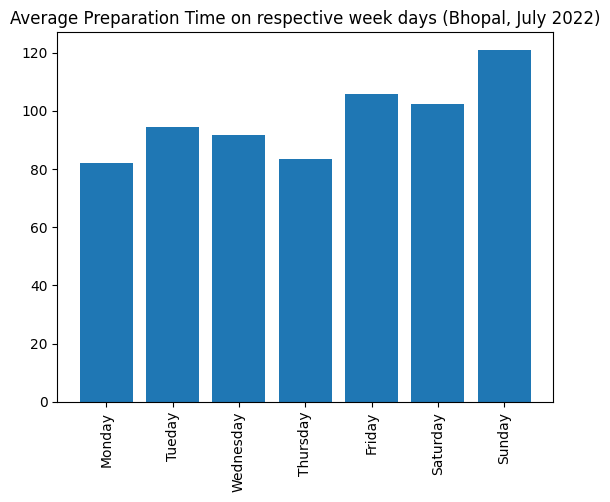

In [200]:
from matplotlib import pyplot
x = ['Monday', 'Tueday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y = [a[1], a[2], a[3], a[4], a[5], a[6], a[7]]
pyplot.bar(x, y)
pyplot.xticks(rotation=90)
pyplot.title("Average Preparation Time on respective week days (Bhopal, July 2022)")
pyplot.show()

In [202]:
a = {}
for ts in allTimeslots:
    print(ts)
    avgPrepTime = mean(overallDF.loc[overallDF['feature_3'] == ts].prep_time.values.tolist())
    a[ts] = avgPrepTime

1.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0


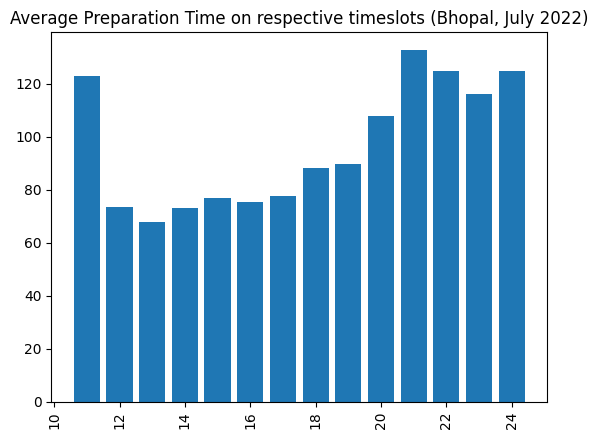

In [205]:
from matplotlib import pyplot
x = [i for i in range(11, 25)]
y = [a[i] for i in range(11, 25)]
pyplot.bar(x, y)
pyplot.xticks(rotation=90)
pyplot.title("Average Preparation Time on respective timeslots (Bhopal, July 2022)")
pyplot.show()

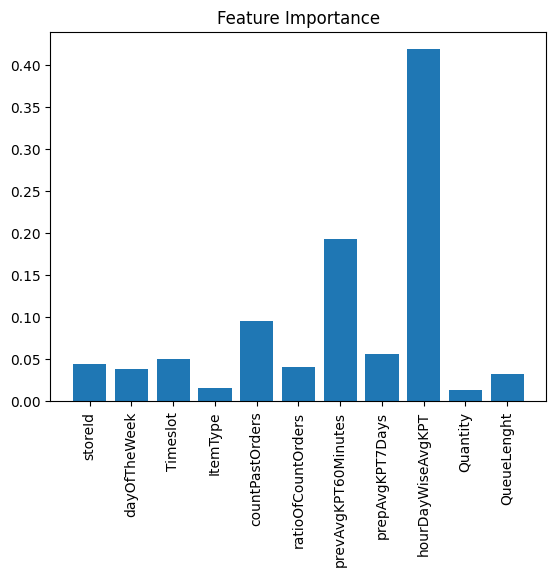

0.9999999087303877


In [226]:
from matplotlib import pyplot
f = ['storeId', 'dayOfTheWeek', 'Timeslot', 'ItemType', 'countPastOrders', 'ratioOfCountOrders', 'prevAvgKPT60Minutes', 'prepAvgKPT7Days', 'hourDayWiseAvgKPT', 'Quantity', 'QueueLenght']
pyplot.bar(f, best_regressor.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.title("Feature Importance")
pyplot.show()
print(sum(best_regressor.feature_importances_))

In [ ]:
# Experiment 1
# remove feature with feature value less than 0.05
# Remaining Features : 1,2,3,5,7,8,9
totalFeatures = (1 +  # store ID (categorical)
                 1 +  # day of the week (categorical)
                 1 +  #timeslot of the day (categorical)
                 1 +  #count past orders in last 30 minutes
                 1 +  # average previous preparation time in last 1 hour
                 1 +  # average previous preparation time in last 7 days
                 1  # average kpt time, hour wise according to the day of the week
                 )  # length of the current queue

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_' + str(i + 1))
# TIME CONSUMING (3m 21s for Bhopal)
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
        # features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        # features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot=60)]
        features += [getPreviousPrepTime(item, timeslot=7 * 24 * 60)]
        features += [getHourWiseAverage(item)]
        # features += [getQuantity(item)]
        # features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 4):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 14)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
                                                (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:,
                       feature_cols]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            updateFeatures(storeId, X_scalednp)
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')


if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                 (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                   (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                             (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()

    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10, 12, 14],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) " + storeId + " :  ", a)

In [ ]:

rmse1 = ((trainingData.prep_time - trainingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

In [ ]:
rmse1, rmse2, meanAbsError, meanAbsError2, medianAbsError, medianAbsError21

In [ ]:
if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 21)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 24)
    lastTime = datetime(2022, 7, 22)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 25)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10, 13],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) "+storeId+" :  ", a)

In [ ]:

rmse1 = ((testingData.prep_time - testingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((testingData.prep_time - testingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

In [ ]:
# Time Consuming (training on first 14 days of July)
restWiseModelsXGB = {}

for storeId in allStoreIds:
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]
    
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    # define the parameter grid to search
    param_grid = {
        'tree_method': ['approx', 'hist', 'auto'],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10, 13],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    restWiseModelsXGB[storeId] = best_regressor
    
    
    X = restWiseDFs[storeId].loc[:, feature_cols]
    y = restWiseDFs[storeId].prep_time.values.tolist()
    predictions = best_regressor.predict(X)
    restWiseDFs[storeId]['predicted_prep_time'] = predictions
    
    a = getRMSE(y, predictions)
    print("RMSE score overall for store (30 days) "+storeId+" :  ", a)

In [ ]:
save_object(restWiseDFs, f'restWiseDFsWithPredictions{city}.pkl')

In [ ]:
save_object(restWiseModelsXGB, f'restWiseModels{city}.pkl')

In [ ]:
def getPredictionHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime) & \
                                       (restWiseDFs[storeId]['prep_time'] != timedelta(0))]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.predicted_prep_time)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.predicted_prep_time).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()
    for i in range(0, len(accuracy)):
        if accuracy[i] < 0:
            accuracy[i] = -1*accuracy[i]
        accuracy[i] = 1-accuracy[i]
    meanAccuracy = statistics.mean(accuracy)
    if not(meanAccuracy > 0 and meanAccuracy < 1):
        print("Mean accuracy is zero: ")
        print(meanAccuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseList = []
meanAbsErrorList = []
medianAbsErrorList = []
stdAbsErrorList = []
meanErrorList = []
medianErrorList = []
stdErrorList = []
meanAccuracyList = []
medianAccuracyList = []
stdAccuracyList = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getPredictionHyperparameters(i,i)
    rmseList.append(rmse)
    meanAbsErrorList.append(meanAbsError)
    medianAbsErrorList.append(medianAbsError)
    stdAbsErrorList.append(stdAbsError)
    meanErrorList.append(meanError)
    medianErrorList.append(medianError)
    stdErrorList.append(stdError)
    meanAccuracyList.append(meanAccuracy)
    medianAccuracyList.append(medianAccuracy)
    stdAccuracyList.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_1.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorList, stdErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyList, stdAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_6.png')



In [ ]:
overallDf = pd.DataFrame()
for storeId in allStoreIds:
        overallDf = pd.concat([overallDf, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
a = overallDf.loc[(overallDf['Oven_Time'] - overallDf['Kitchen_Display_Time'] < timedelta(seconds=1))]

In [ ]:
a

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.8, 1)
plt.bar(x, medianAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_7.png')


In [ ]:
# baseline approach
# Hourwise avg 

weekdayHourWiseAvg = {}
weekendHourWiseAvg = {}
for store in allStoreIds:
    weekdayHourWiseAvg[store] = {}
    weekendHourWiseAvg[store] = {}
for i in range(1, 15):
    dt = datetime(2022, 7, i)
    for storeId in allStoreIds:
        df = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= dt) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < dt+timedelta(days=1))]
        for index, item in df.iterrows():
            ts = getTimeslot(item['Kitchen_Display_Time'])
            if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
                if ts not in weekendHourWiseAvg[storeId]:
                    weekendHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekendHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekendHourWiseAvg[storeId][ts]['cnt'] += 1
            else:
                if ts not in weekdayHourWiseAvg[storeId]:
                    weekdayHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekdayHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekdayHourWiseAvg[storeId][ts]['cnt'] += 1

for storeId in allStoreIds:
    for ts in weekdayHourWiseAvg[storeId].keys():
        weekdayHourWiseAvg[storeId][ts]['val'] = weekdayHourWiseAvg[storeId][ts]['val']/weekdayHourWiseAvg[storeId][ts]['cnt']
    for ts in weekendHourWiseAvg[storeId].keys():
        weekendHourWiseAvg[storeId][ts]['val'] = weekendHourWiseAvg[storeId][ts]['val']/weekendHourWiseAvg[storeId][ts]['cnt']
        

        
        

In [ ]:
overallDF = pd.DataFrame()
for storeId in allStoreIds:
    overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
avgs = []
for index, item in overallDF.iterrows():
    ts = getTimeslot(item['Kitchen_Display_Time'])
    storeId = item['Location_Code']
    if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
        if(ts not in weekendHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekendHourWiseAvg[storeId][ts]['val'] )
    else:
        if(ts not in weekdayHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekdayHourWiseAvg[storeId][ts]['val'] )


In [ ]:
overallDF['hourwise_avg'] = avgs

In [ ]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = overallDF.loc[overallDF['Location_Code'] == storeId]

In [ ]:
def getBaselineHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime)]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.hourwise_avg) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.hourwise_avg)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.hourwise_avg).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = ((df.prep_time - abs(df.prep_time - df.hourwise_avg))/df.prep_time).values.tolist()
    meanAccuracy = statistics.mean(accuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseListBL = []
meanAbsErrorListBL = []
medianAbsErrorListBL = []
stdAbsErrorListBL = []
meanErrorListBL = []
medianErrorListBL = []
stdErrorListBL = []
meanAccuracyListBL = []
medianAccuracyListBL = []
stdAccuracyListBL = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getBaselineHyperparameters(i,i)
    rmseListBL.append(rmse)
    meanAbsErrorListBL.append(meanAbsError)
    medianAbsErrorListBL.append(medianAbsError)
    stdAbsErrorListBL.append(stdAbsError)
    meanErrorListBL.append(meanError)
    medianErrorListBL.append(medianError)
    stdErrorListBL.append(stdError)
    meanAccuracyListBL.append(meanAccuracy)
    medianAccuracyListBL.append(medianAccuracy)
    stdAccuracyListBL.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Baseline prediction")
plt.savefig(f'BL_{city}_1.png')

In [ ]:
rmseListBL

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorListBL, stdErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyListBL, stdAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_6.png')



In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.7, 1)
plt.bar(x, medianAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_7.png')


In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr)) = getPredictionHyperparameters(1, 14)

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe)) = getPredictionHyperparameters(15, 31)

In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr))

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe))

In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, rmseList, label="xgboost model")
plt.plot(x, rmseListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE Comparison on the respective day")
plt.title("Model vs Baseline in RMSE values")
plt.legend()
plt.savefig(f'BL_{city}_7.png')


In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, medianAbsErrorList, label="xgboost model")
plt.plot(x, medianAbsErrorListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Median Abs Error Comparison on the respective day")
plt.title("Model vs Baseline in Median Abs Error")
plt.legend()
plt.savefig(f'BL_{city}_8.png')

In [ ]:
def getErrorSlot(error):
    return (error//5)*5

cnt = {}
for index, item in overallDF.iterrows():
    error = (item['prep_time'] - item['predicted_prep_time'])/60
    lts = getErrorSlot(error)
    if(lts not in cnt):
        cnt[lts]=1
    else:
        cnt[lts]+=1

In [ ]:
ranges = sorted(cnt.keys())

In [ ]:
cnt[-10]

In [ ]:
cnt[-5]

In [ ]:
cnt[0]

In [ ]:
for i in range(-)